# Water Mission, IBM

## Analysis of  the midline survey grouped by NationalQuintile 

This Notebook offers analysis of responses form the midline survey for households in the rural communities: Lulembela, Chanhomba and Gidewari of Tanzania. Original dataset was split to 3 the subsets for each community also responses were grouped by wealth index in the each community's dataset in our case it is NationalQuintile. You can find list of the report sections created using this notebook in **The Table of Content** section below.

The Notebook processes the dataset from Tanzania's districts. Dataset might be in the CSV or EXCEL format.

## Table of Content
* [Library Imports and Settings](#settings)
 * [Global Variables](#variables)
 * [Library Imports](#imports)
* [DataFrames creation and Data Pre-processing](#preprocessing)
 * [Functions](#functions)
 * [DataFrames creation](#ml_df_creation)
* [Groups analysis](#ml_analysis)
 * [Lulembela](#lulembela)
 * [Chanhomba](#chanhomba)
 * [Gidewari](#gidewari)
 * [Comparison of the groups between the rural communities](#compare_communities)

<a id="settings"></a>
# Library Imports and Settings

This section contains import statements for all the libraries used in the notebook and various configuration settings we rely on.

<a id="variables"></a>
## Global Variables

The notebook allows you switching your environment between local environment and Bluemix cloud.

If you run the notebook on your local system set **environment** variable to local and the path to the data file using **root** variable. If using Data Science Experience, set **environment** variable to any value different from **_local_** (for example, you may use **_bluemix_** value to make it more clear).


In [2]:
environment = 'bluemix'
root = 'c:\\sparknotes\\'

If using Data Science Experience, the dataset file is stored on the Bluemix cloud and we need to define credeantials for accessing it.

If you need to use another Object storage in Data Science Experience, you have to change **credentials** variable below. You may create an empty cell, click **_Find and Add Data_** menu (at the top right side), then choose **_Insert to code_** for any file and pick out **_Insert Credentials_**. New credentials will appear in the active cell. You may rename the fragment JSON to **credentials** and drop or comment the older one.

In [3]:
# @hidden_cell
credentials = {
  'auth_url':'https://identity.open.softlayer.com',
  'project':'object_storage_a2fb7d55_67e7_4258_a192_04215bdfe373',
  'project_id':'dbb445bcb1014178ba6b418a8d14c2e4',
  'region':'dallas',
  'user_id':'2e7ed539b10c4b939a08b476167196de',
  'domain_id':'33dfa34c5bad4cf5b34da9def543de97',
  'domain_name':'907035',
  'username':'member_8d133283f3260061be9bb8a15c4cebfc424d2a41',
  'password':"""yLnZVC1BG&]-X7Y?""",
  'container':'WaterMissionWorldBank',
  'tenantId':'undefined',
  'filename':'Rural_ML_Master.xlsx'
}

<a id="imports"></a>
## Library Imports

In [4]:
import pandas as pd
import csv
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import numpy as np
from collections import OrderedDict
import math
import types
from sklearn import cluster
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn import preprocessing
from sklearn.preprocessing import scale
from itertools import cycle
from io import StringIO, BytesIO
import requests
import json
try:
    import seaborn as sns
except:
    import pip    
    pip.main(['install', 'seaborn'])    
    import seaborn as sns

<a id="preprocessing"></a>
# DataFrames creation and Data Pre-processing
This section aggregates code to load data, definitions of functions used to pre-process data, and code to prepare data.

<a id="functions"></a>
## Functions
This section defines functions used for data processing.

In [5]:
# @hidden_cell
# This function accesses a file in your Object Storage using 'credentials' variable defined above.
def get_object_storage_file_with_credentials(filename, credentials):
    """This functions returns a BytesIO object containing the file content from Bluemix Object Storage."""

    url1 = ''.join([credentials['auth_url'], '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', credentials['container'], '/', filename])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return BytesIO(resp2.content)

def get_file_content(filename):
    if(environment == 'local'):
        return root + filename
    else:
        return get_object_storage_file_with_credentials(filename, credentials)

In [6]:
def floatExt(val):
    try:
        res = float(val)
    except ValueError:
        if val == '':
            res = float('nan')
        else:
            res = float(val.replace(',','.'))
    return res

def ps_to_int(val):
    if val=='other':
        return 8
    else:
        return int(val)

In [7]:
def get_age_group(age):
    group = 'Unknown'   
    if (18 <= age <= 29):
        group = '18-29 years'
    elif (30 <= age <= 39):
        group = '30-39 years'
    elif (40 <= age <= 49):
        group = '40-49 years'
    elif (50 <= age <= 59):
        group = '50-59 years'
    elif (age >= 60):
        group = '60+ years'
    return group


In [8]:
def show_diff_for(df, cloumn_name, title, legend_labels, box_anchor, group_by='Group' ):
    pt_countr_all = df.pivot_table(values='Count', index=[group_by], columns=[cloumn_name], aggfunc=np.sum, fill_value=0)
    pt_countr_all['sum'] = pt_countr_all.sum(axis=1)
    pt_countr_all = pt_countr_all.div(pt_countr_all.iloc[:,-1], axis=0 ).mul(100)
    del pt_countr_all['sum']
    pt_countr_all.plot(subplots=False, figsize=(23, 10),  kind='bar')
    L = plt.legend(loc='upper right', bbox_to_anchor=box_anchor, fontsize=16)
    for i in range(len(legend_labels)):
        L.get_texts()[i].set_text(legend_labels[i])
        
    plt.title(title, fontsize=29)    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=20)   
    plt.ylabel('Percent', fontsize=20) 
    axes = plt.gca()
    axes.set_ylim([0,100])
    axes.xaxis.label.set_size(20)
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    plt.show()

def show_reasons_diff_2(df, reasons, aggregations, title='', group_by='Group',  bbbox_to_anchor=(1, 1)):   
    df_res = df.groupby(group_by).agg(aggregations).reset_index()
    legend_labels = []
  
    for k, v in reasons.items():
        df_tmp = df.pivot_table(values='Count', index=[group_by],
                                        columns=[k], 
                                        aggfunc=np.sum, fill_value=0).reset_index()
        try:
            vals = df_tmp[1]
        except:
            vals = pd.Series( data=0, dtype=int, index = df_tmp.index )
        df_res[v] = vals / df_res['Count'] * 100
        legend_labels.append(v)
    
    group_names = df_res[group_by].as_matrix()
    
    del df_res['Count']
    del df_res[group_by]    
    df_res.plot(subplots=False, figsize=(23, 10),  kind='bar')
    L = plt.legend(loc='upper right', bbox_to_anchor=bbbox_to_anchor, fontsize=20)
    for i in range(len(legend_labels)):
        L.get_texts()[i].set_text(legend_labels[i])
        
    plt.title(title, fontsize=29)    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=20)  
    plt.xticks(range(len(group_names)), group_names)
    plt.ylabel('Percent', fontsize=25)
    plt.xlabel(group_by, fontsize=25)
    axes = plt.gca()
    axes.set_ylim([0,100])
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    plt.show()

def show_diff_between_3_communities_nq(df1, df2, df3, c_name, f_name, comm_names, title, y_label):    
    df_pt1 = df1[['NationalQuintile', c_name]]
    df_pt2 = df2[['NationalQuintile', c_name]]
    df_pt3 = df3[['NationalQuintile', c_name]]
    aggregations = {        
         c_name: {
                '': f_name

            }        
    }
    df_g1 = df_pt1.groupby(['NationalQuintile']).agg(aggregations).reset_index()
    df_g2 = df_pt2.groupby(['NationalQuintile']).agg(aggregations).reset_index()
    df_g3 = df_pt3.groupby(['NationalQuintile']).agg(aggregations).reset_index()
    
    df_g1.rename(inplace=True, columns={c_name: comm_names[0]})
    df_g2.rename(inplace=True, columns={c_name: comm_names[1]})
    df_g3.rename(inplace=True, columns={c_name: comm_names[2]})
    #print(df_g2)
    del df_g2['NationalQuintile']
    del df_g3['NationalQuintile']
    df_g1 = df_g1.join(df_g2)
    df_g1 = df_g1.join(df_g3)     
    group_names = df_g1['NationalQuintile']
    del df_g1['NationalQuintile']
    df_g1.plot(subplots=False, figsize=(23, 10),  kind='bar')  
    L = plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1.0), fontsize=20)
    for i in range(len(comm_names)):
        L.get_texts()[i].set_text(comm_names[i])
    plt.title(title, fontsize=29)    
    plt.rcParams.update({'font.size': 16})
    plt.tick_params(axis='both', which='major', labelsize=20)  
    plt.xticks(range(len(group_names)), group_names)
    plt.ylabel(y_label, fontsize=25)
    plt.xlabel('NationalQuintile', fontsize=25)
    axes = plt.gca()
    locs, labels = plt.xticks()
    plt.setp(labels, rotation=0)
    plt.show()

In [9]:
def get_group_measurements_quintile(df):
    df_pt = df[['NationalQuintile','Count', 'WaterExpenditure','AmountOfWater']]
    aggregations = {
        'Count': {
                'Respondents': 'sum'

            },
        'WaterExpenditure': {
                'Average value': 'mean'

            },
        'AmountOfWater': {
                'Average value': 'mean'
            }
    }
    df_g = df_pt.groupby(['NationalQuintile']).agg(aggregations)
    df_g = df_g.apply(lambda x: np.round(x,2))    
    return df_g

<a id='ml_df_creation'></a>
## DataFrames creation

Load Midline survey from the Microsoft Excel file and create DataFrame instance. For loading .xls(.xlsx) file need set up **_sheetname_** parameter. In our case this is **Rural_MLdata**

In [11]:
df_survey_apr = pd.read_excel(get_file_content('Rural_ML_Master.xlsx'), sheetname='Rural_MLdata', header=0, 
                              converters={'Phone_Number': str, 'WaterExpenditure': floatExt, 'AmountOfWater': floatExt,
                                          'PrimarySource': ps_to_int})

Rename Winote columns understandable names

In [12]:
df_survey_apr.rename(columns={'Q1': 'TVSet', 'Q2': 'Iron', 'Q3': 'MobilePhone', 'Q4': 'BankAccount',
                              'Q5': 'EnergyForCooking', 'Q6': 'FloorMaterial', 'Q7': 'RoofMaterial', 
                              'Q8': 'SourceOfLighting'}, inplace=True)
df_survey_apr['Count'] = 1

Normalize FloorMaterial values to Baseline survey's answers

In [13]:
df_survey_apr.loc[df_survey_apr['FloorMaterial'] == 1, 'FloorMaterial'] = 0
df_survey_apr.loc[df_survey_apr['FloorMaterial'] == 2, 'FloorMaterial'] = 1

Normalize BankAccount values to Baseline survey's answers

In [14]:
df_survey_apr.loc[df_survey_apr['BankAccount'] == 2, 'BankAccount'] = 0

Showing number of respondents in each community

In [15]:
df_ml = df_survey_apr.groupby(['CommName']).Phone_Number.count().reset_index()
df_ml.columns = ['CommName', 'Count']
df_ml['Percent'] = (df_ml.Count / len(df_survey_apr) * 100).round(2)
df_ml

,CommName,Count,Percent
0,Chanhumba,178,33.58
1,Gidewari,105,19.81
2,Lulembela,247,46.60


Create DataFrame inctance for Lulembela community

In [16]:
df_Lulembela_m = df_survey_apr[df_survey_apr.CommName == 'Lulembela']
df_Lulembela_m.shape

(247, 106)

Create DataFrame inctance for Chanhomba community

In [17]:
df_Chanhomba_m = df_survey_apr[df_survey_apr.CommName == 'Chanhumba']
df_Chanhomba_m.shape

(178, 106)

Create DataFrame inctance for Gidewari community

In [18]:
df_Gidewari_m = df_survey_apr[df_survey_apr.CommName == 'Gidewari']
df_Gidewari_m.shape

(105, 106)

<a id='ml_analysis'></a>
# Groups analysis

<a id='lulembela'></a>
## Lulembela

Show number of respondents, water consumption and money expenditure on water for each group in the dataset that came from Lulembela

In [19]:
get_group_measurements_quintile(df_Lulembela_m)

,AmountOfWater,WaterExpenditure,Count
,Average value,Average value,Respondents
NationalQuintile,,,
1,20.00,1000.00,1
2,32.77,1808.13,31
3,37.47,2790.00,30
4,42.85,2893.18,66
5,41.93,3296.81,119


In [20]:
df_Lulembela_m = df_Lulembela_m.assign(AgeGroup = df_Lulembela_m.Age.apply(lambda a: get_age_group(a)))

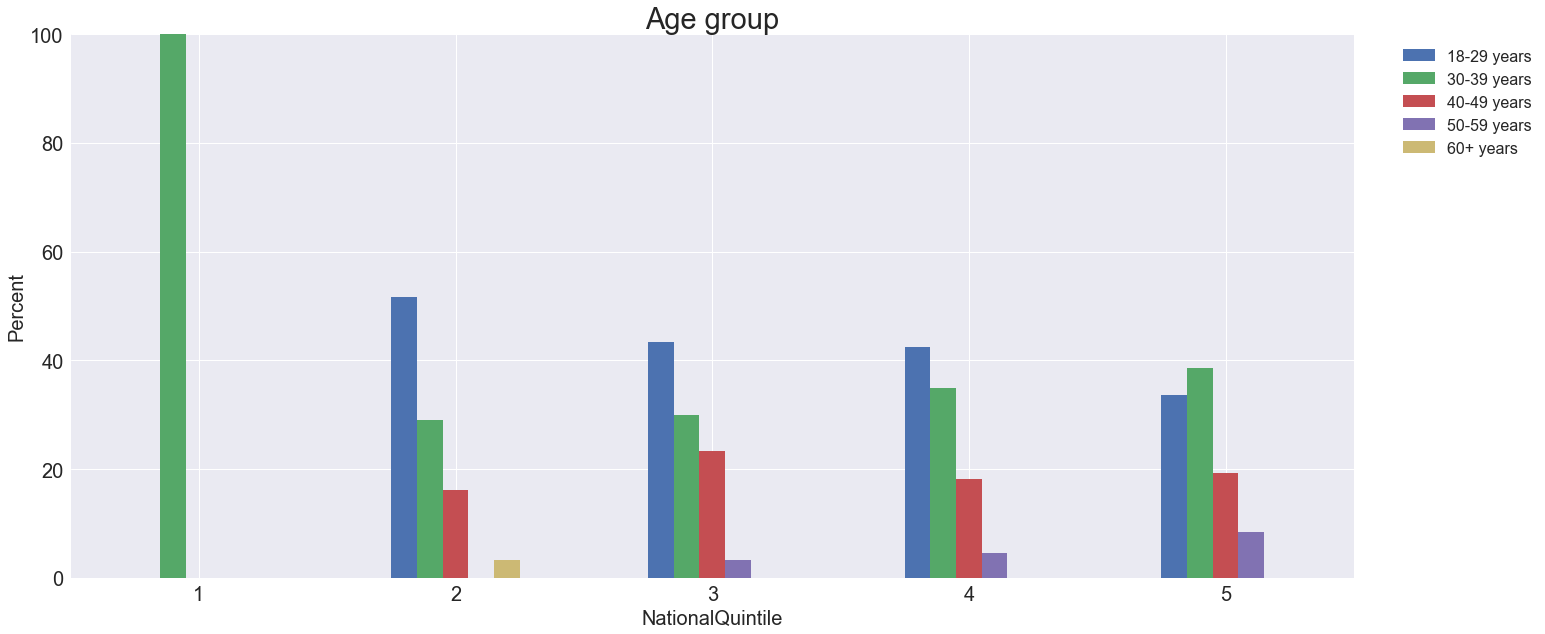

In [21]:
show_diff_for(df_Lulembela_m, 'AgeGroup', 'Age group', [], (1.15, 1.0), group_by='NationalQuintile')

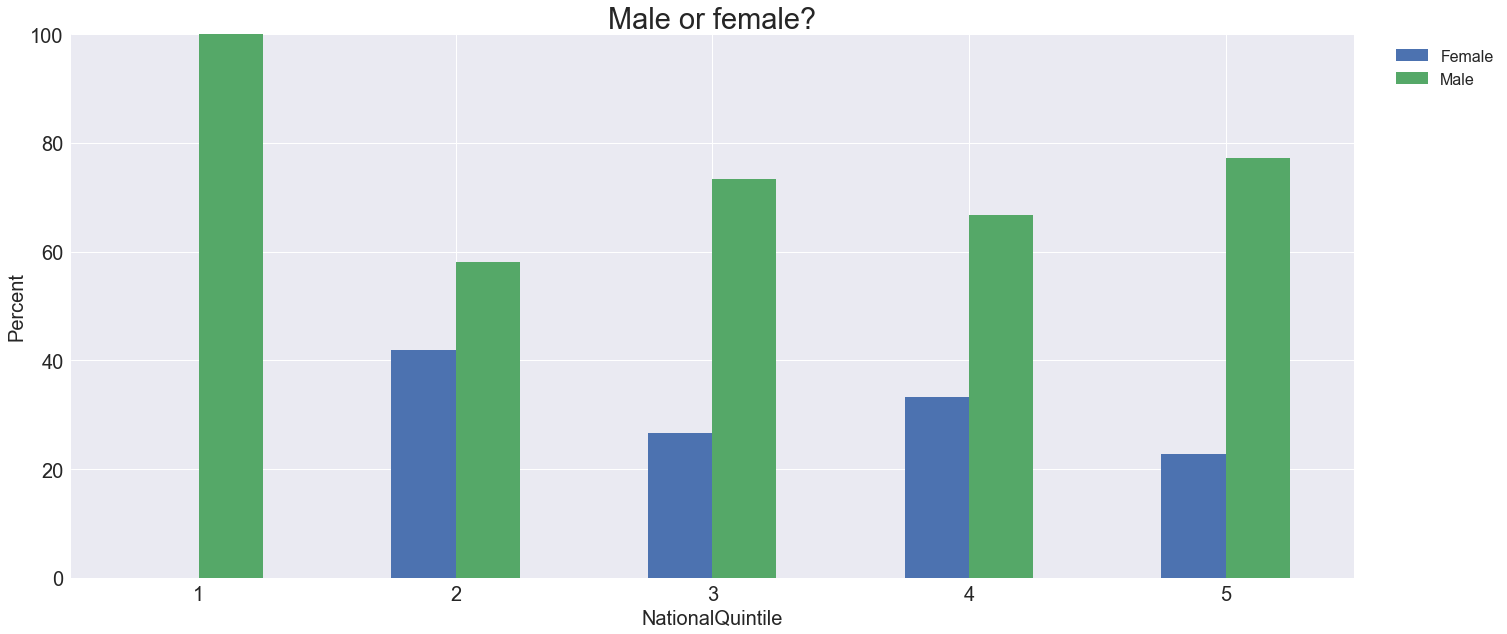

In [22]:
show_diff_for(df_Lulembela_m, 'Gender', 'Male or female?', ['Female', 'Male'], (1.12, 1.0), group_by='NationalQuintile')

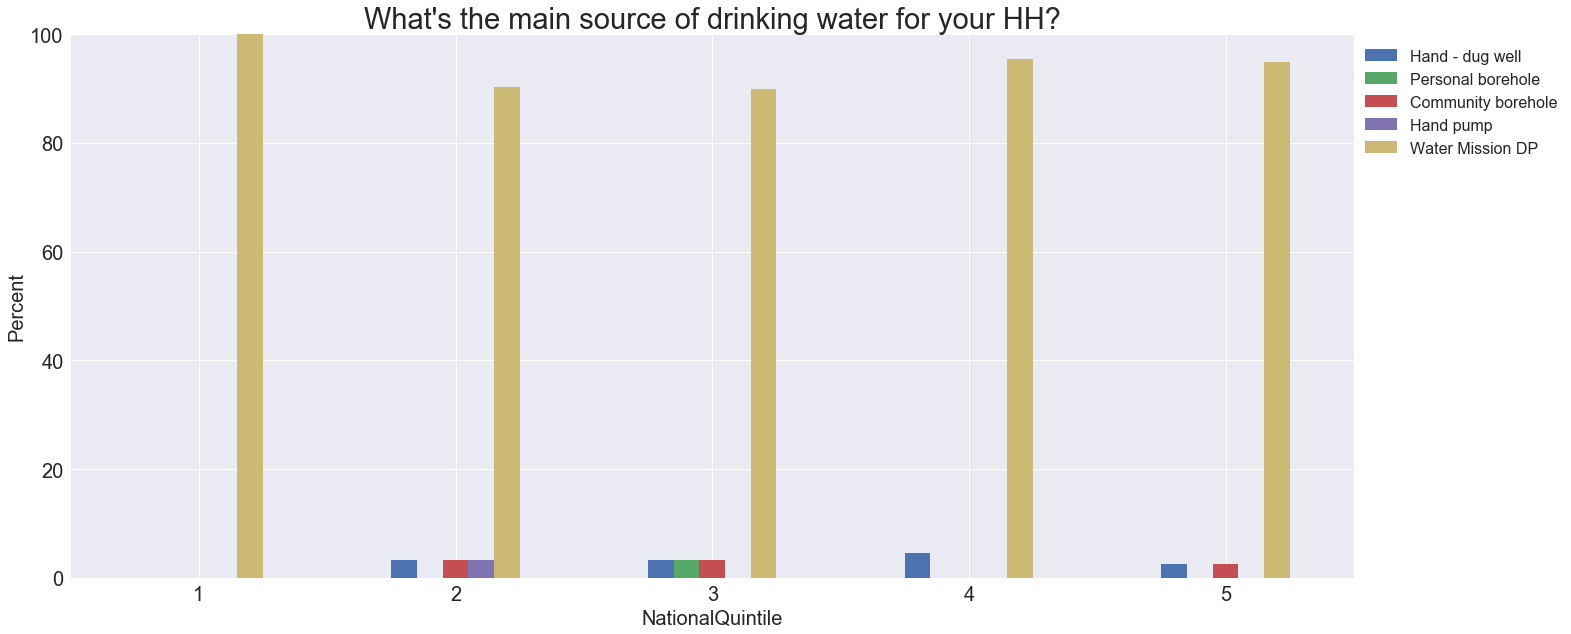

In [23]:
source_of_water =['Hand - dug well', 'Personal borehole', 'Community borehole', 'Hand pump', 'Water Mission DP']
show_diff_for(df_Lulembela_m, 'PrimarySource', "What's the main source of drinking water for your HH?", source_of_water, (1.17, 1.0), group_by='NationalQuintile')

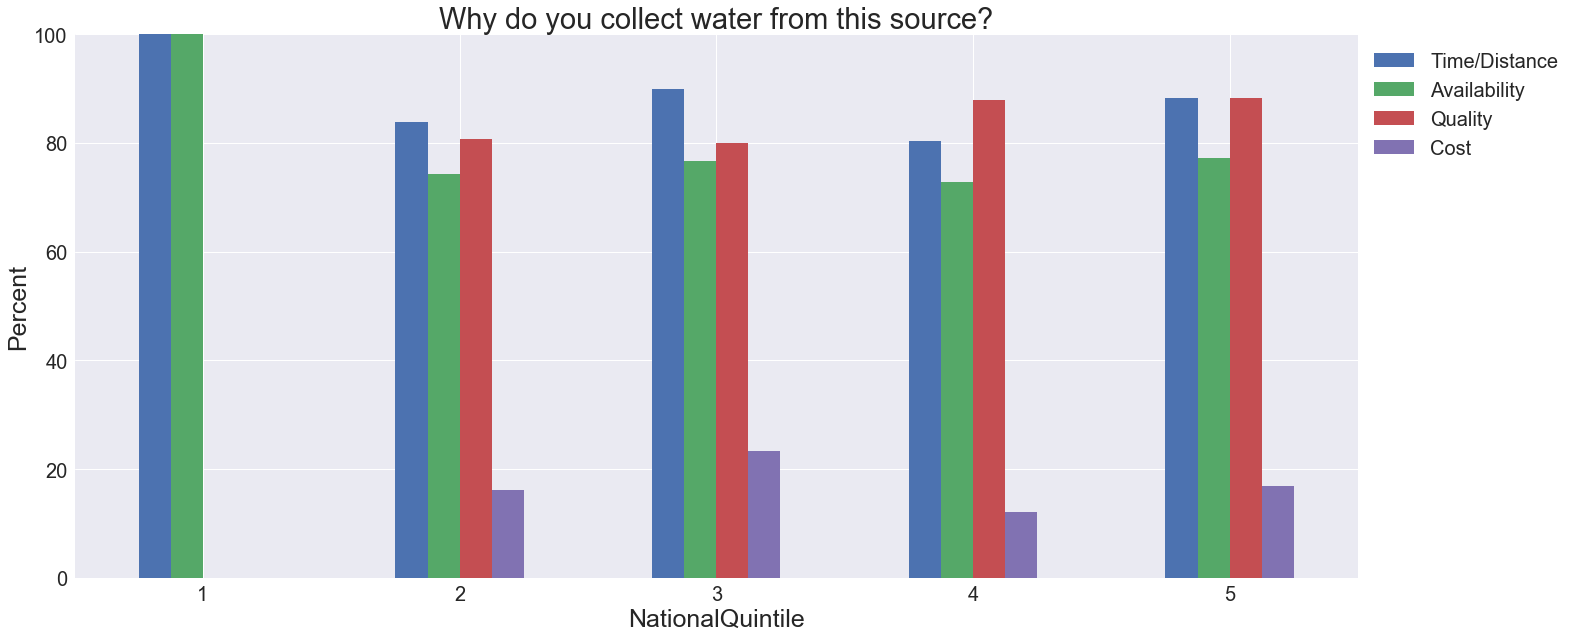

In [24]:
count_agg = {'Count': {'': 'sum'}}
show_reasons_diff_2(df_Lulembela_m, {'Reason/Cost': 'Cost', 'Reason/Availability': 'Availability', 
                                     'Reason/Time_Distance': 'Time/Distance', 'Reason/Quality': 'Quality'}, 
                    count_agg, title='Why do you collect water from this source?',
                    group_by='NationalQuintile', bbbox_to_anchor=(1.17, 1) ) 

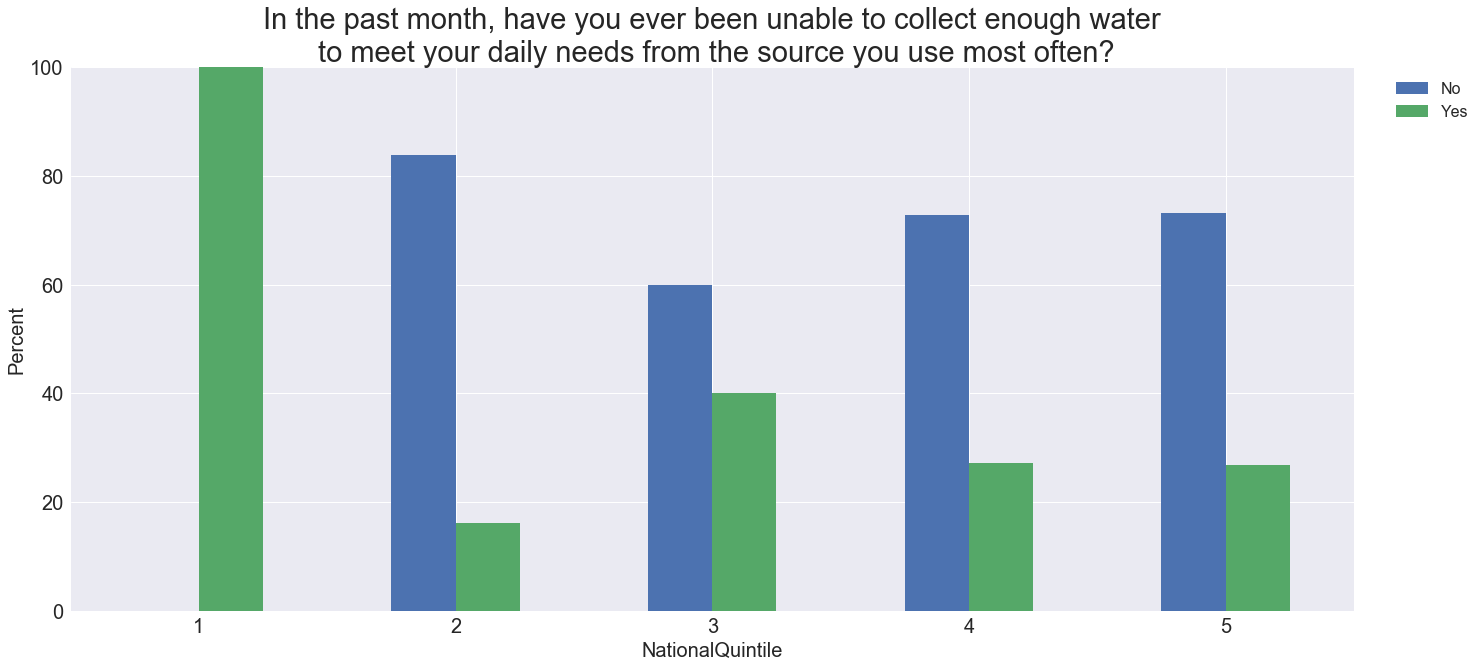

In [25]:
show_diff_for(df_Lulembela_m, 'WaterAvailability', 'In the past month, have you ever been unable to collect enough water\n to meet your daily needs from the source you use most often?',
              ['No', 'Yes'], (1.1, 1.0), group_by='NationalQuintile')

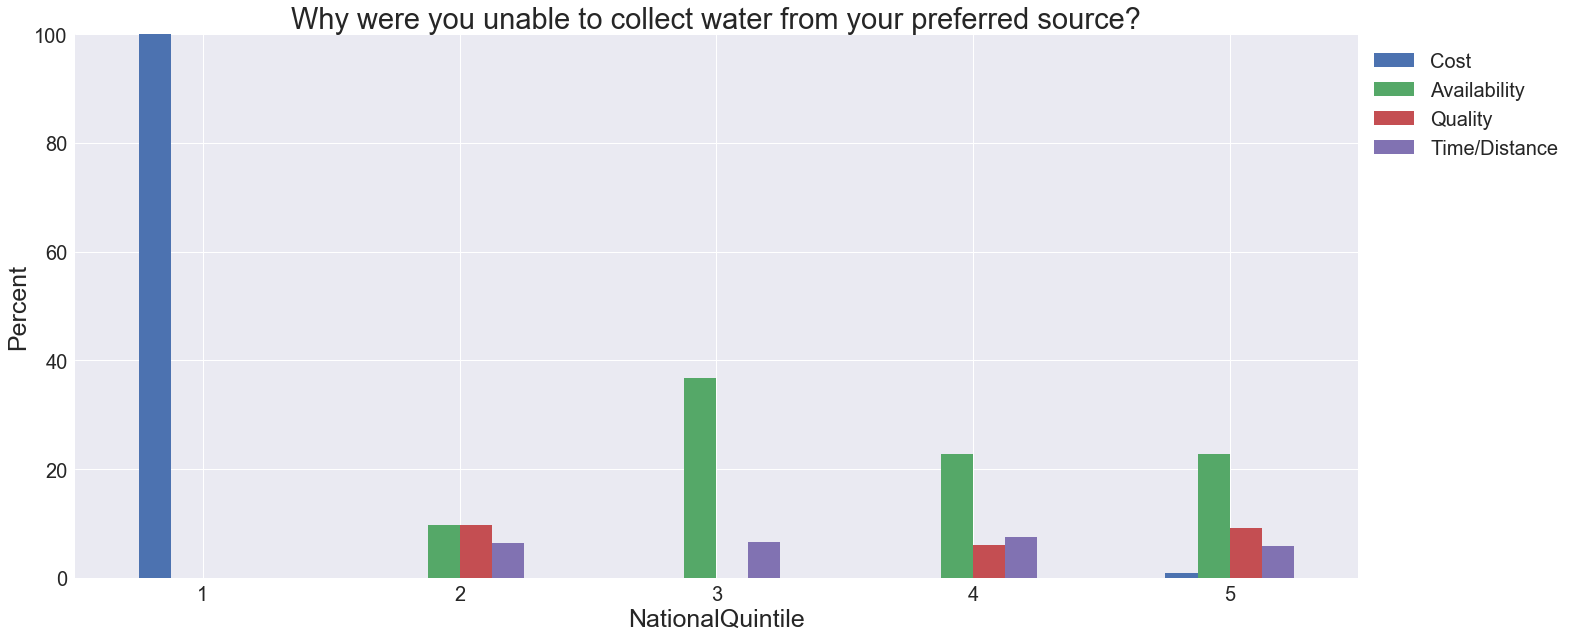

In [26]:
count_agg = {'Count': {'': 'sum'}}
show_reasons_diff_2(df_Lulembela_m, {'AvailReason/Cost': 'Cost', 'AvailReason/Availability': 'Availability', 
                                     'AvailReason/Time_Distance': 'Time/Distance', 'AvailReason/Quality': 'Quality'}, 
                    count_agg, title='Why were you unable to collect water from your preferred source?',
                    group_by='NationalQuintile', bbbox_to_anchor=(1.17, 1) ) 

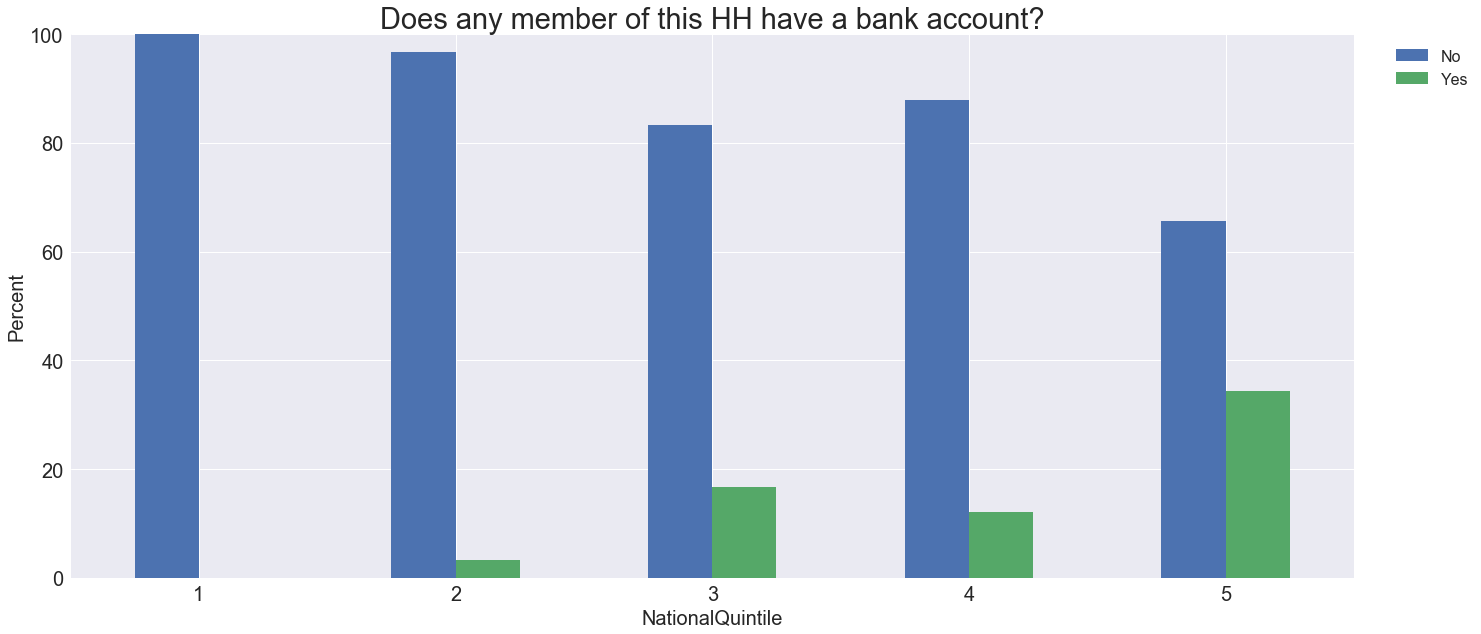

In [27]:
show_diff_for(df_Lulembela_m, 'BankAccount', 'Does any member of this HH have a bank account?', ['No', 'Yes'], (1.1, 1.0), group_by='NationalQuintile')

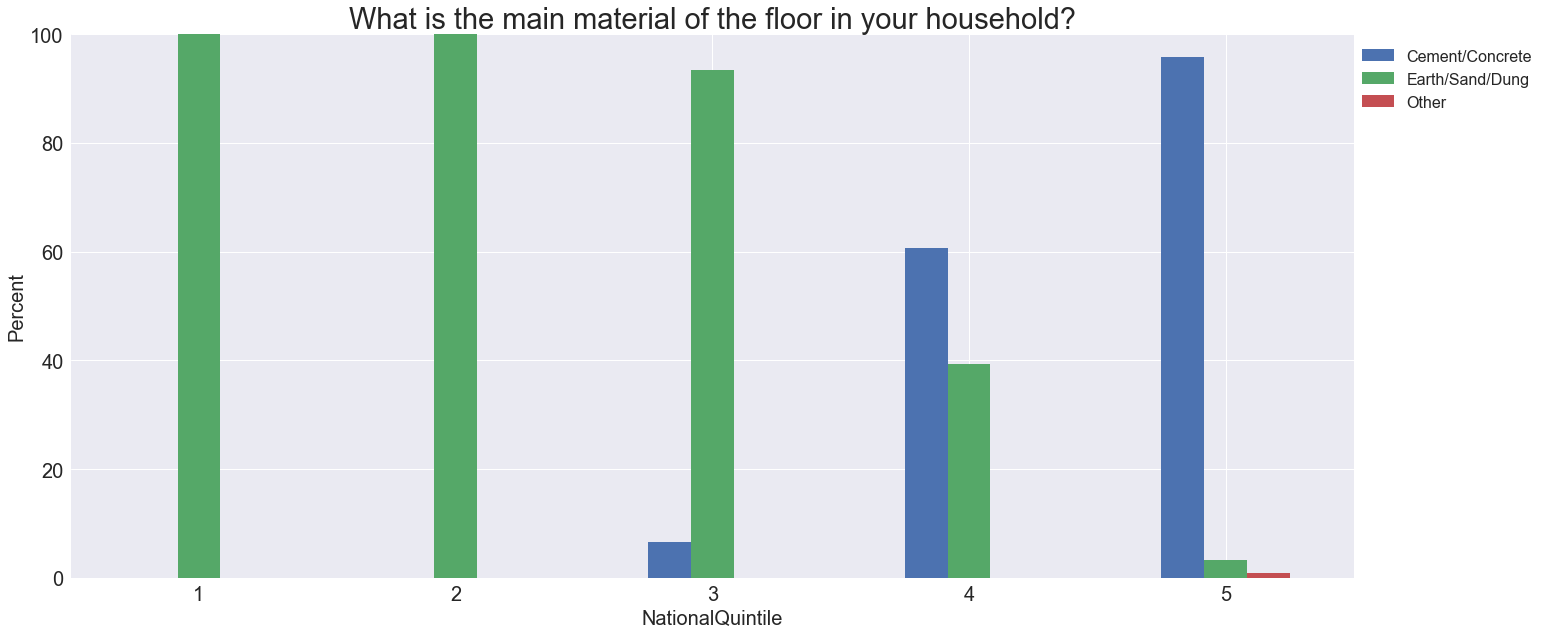

In [28]:
show_diff_for(df_Lulembela_m, 'FloorMaterial', 'What is the main material of the floor in your household?',
              ['Cement/Concrete', 'Earth/Sand/Dung', 'Other'], (1.15, 1.0), group_by='NationalQuintile')

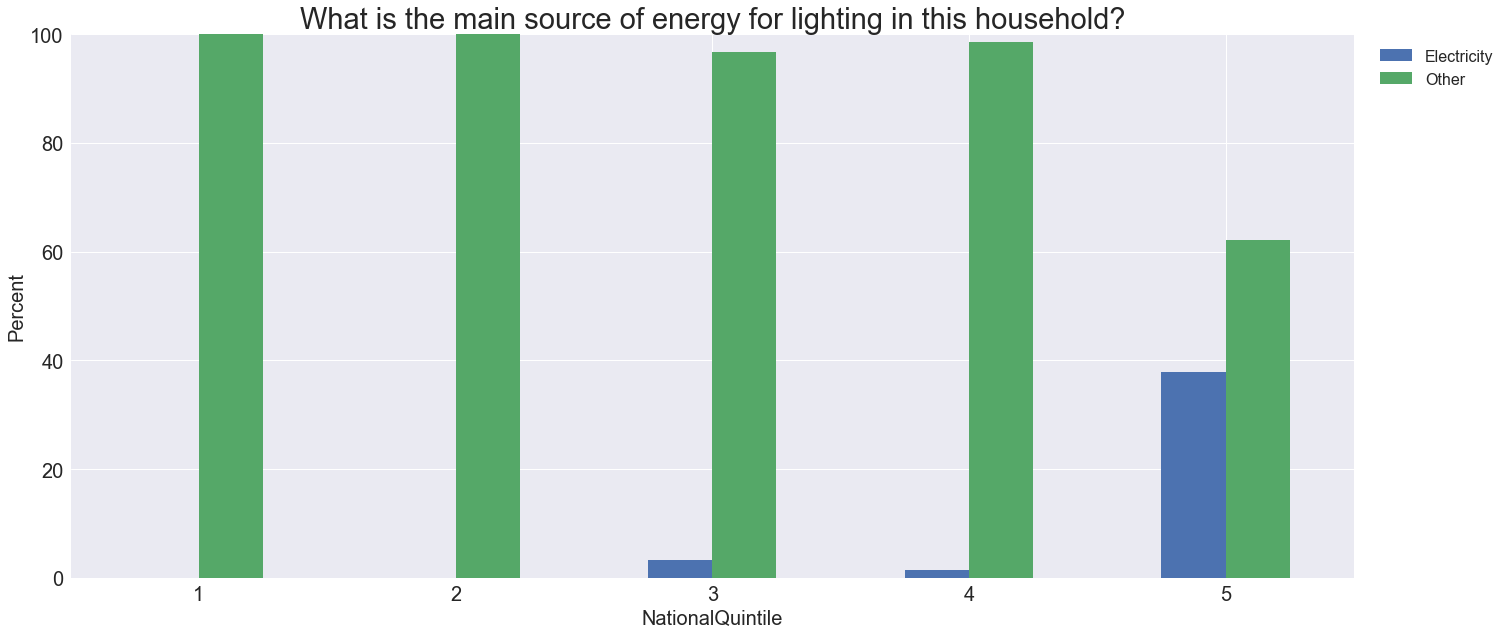

In [29]:
show_diff_for(df_Lulembela_m, 'SourceOfLighting', 
              'What is the main source of energy for lighting in this household?', 
              ['Electricity', 'Other'], (1.12, 1.0), group_by='NationalQuintile')

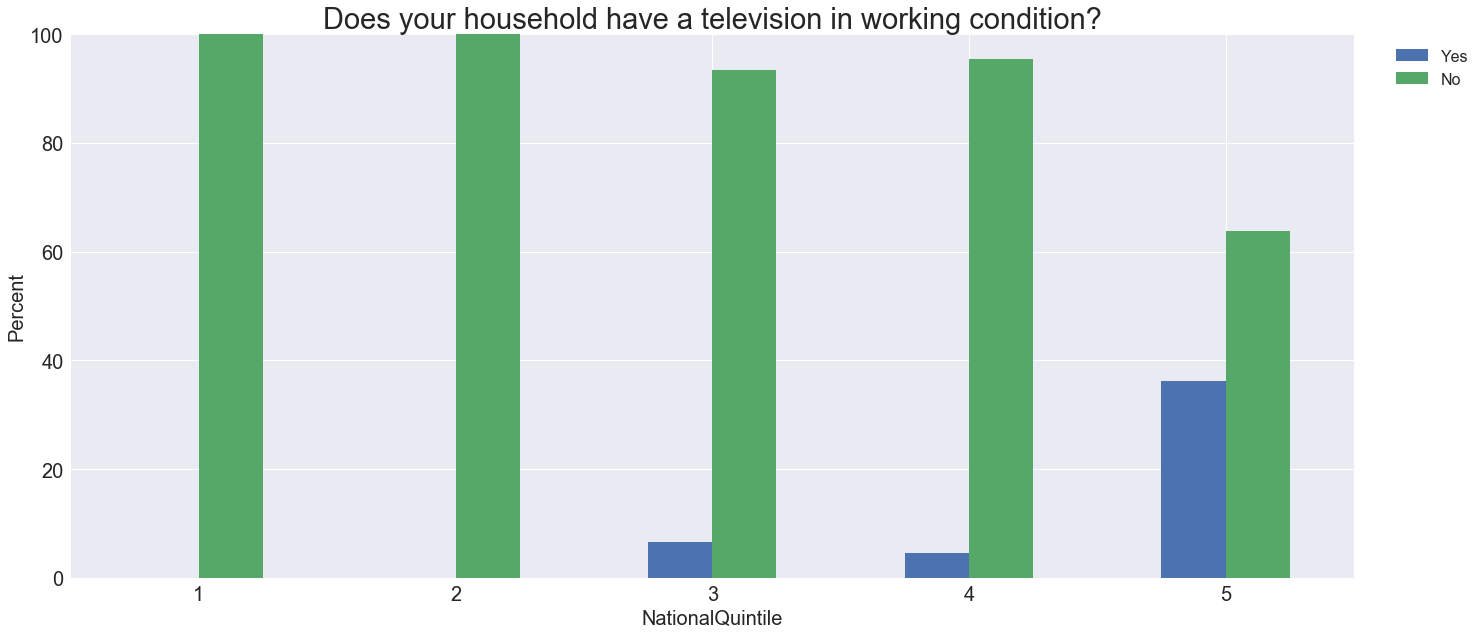

In [30]:
show_diff_for(df_Lulembela_m, 'TVSet', 
              'Does your household have a television in working condition?', 
              ['Yes', 'No'], (1.1, 1.0), group_by='NationalQuintile')

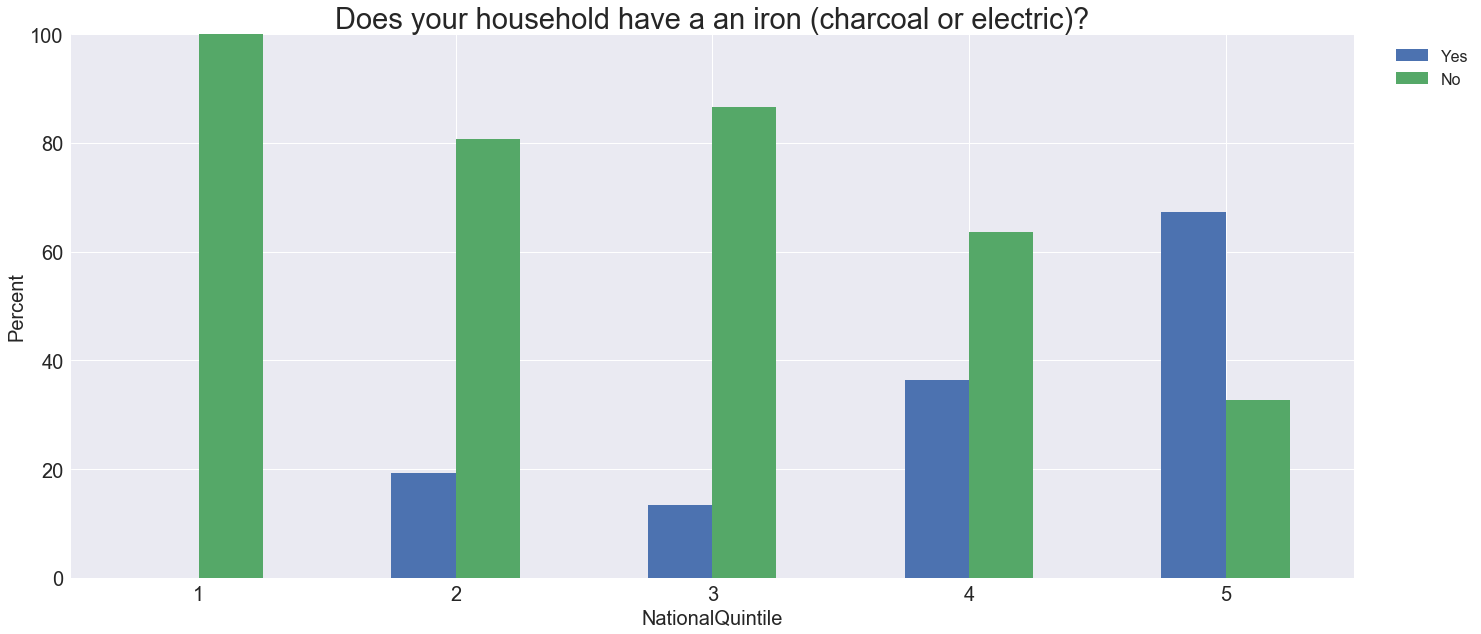

In [31]:
show_diff_for(df_Lulembela_m, 'Iron', 
              'Does your household have a an iron (charcoal or electric)?', 
              ['Yes', 'No'], (1.1, 1.0), group_by='NationalQuintile')

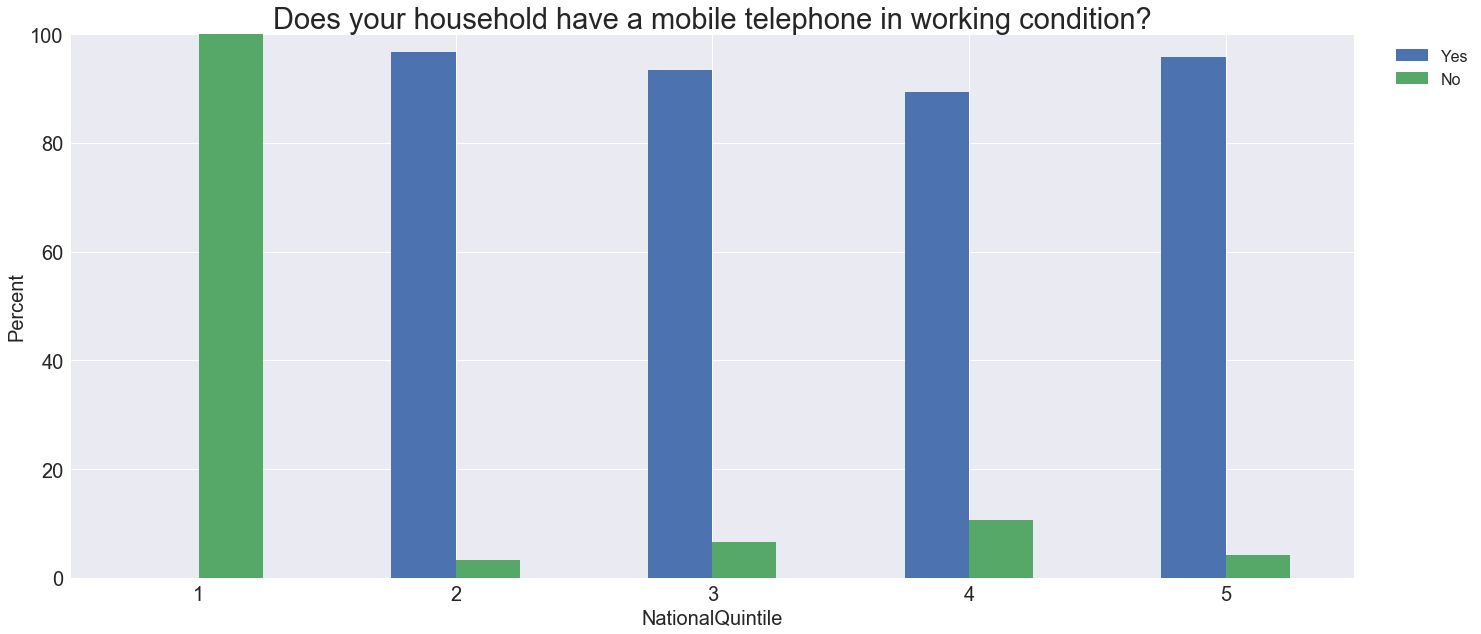

In [32]:
show_diff_for(df_Lulembela_m, 'MobilePhone', 
              'Does your household have a mobile telephone in working condition?', 
              ['Yes', 'No'], (1.1, 1.0), group_by='NationalQuintile')

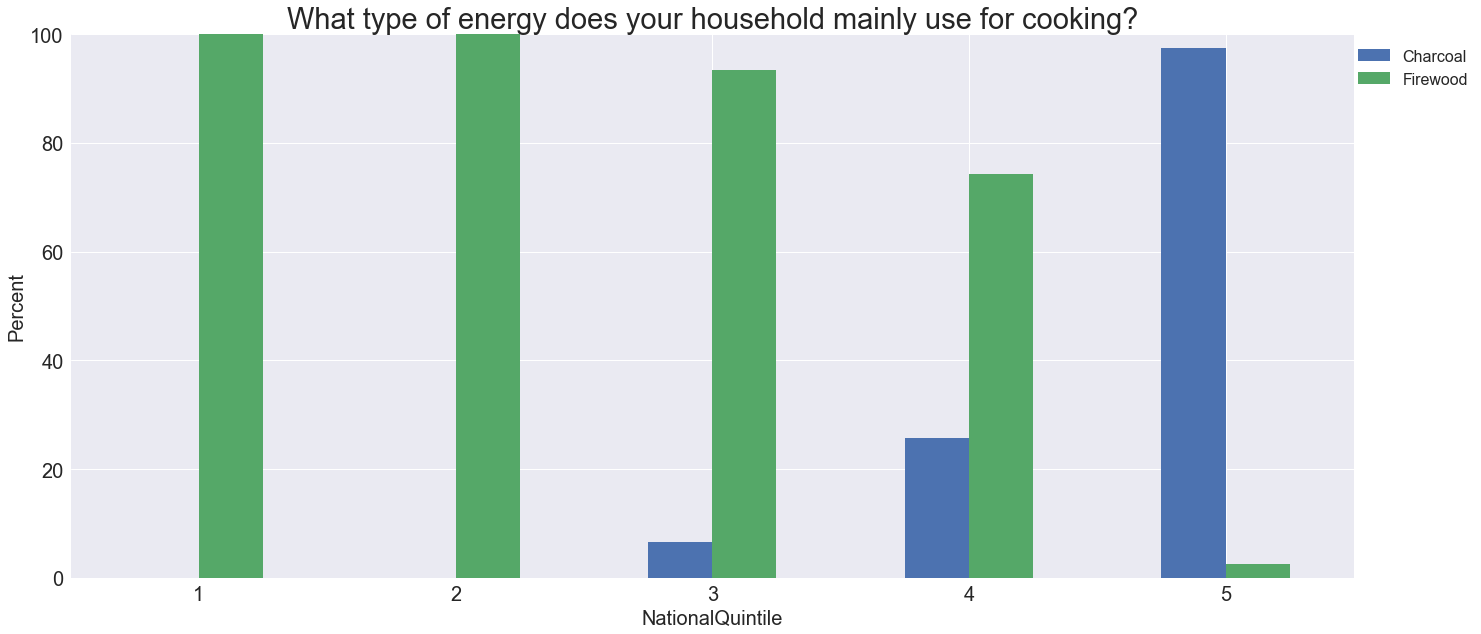

In [33]:
show_diff_for(df_Lulembela_m, 'EnergyForCooking', 
              'What type of energy does your household mainly use for cooking?', 
              ['Charcoal', 'Firewood'], (1.1, 1.0), group_by='NationalQuintile')

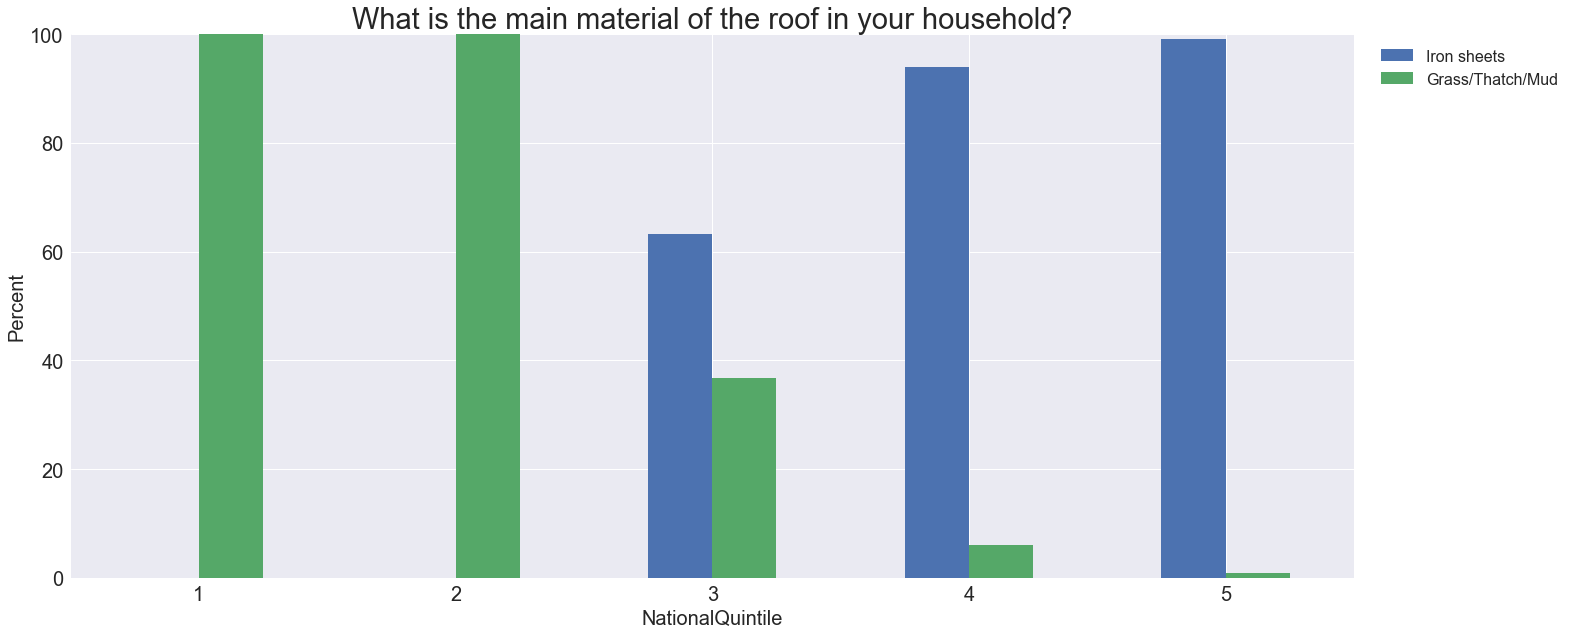

In [34]:
show_diff_for(df_Lulembela_m, 'RoofMaterial', 
              'What is the main material of the roof in your household?', 
              ['Iron sheets', 'Grass/Thatch/Mud'], (1.17, 1.0), group_by='NationalQuintile')

<a id='chanhomba'></a>
## Chanhomba

Show number of respondents, water consumption and money expenditure on water for each group in the dataset that came from Chanhomba

In [35]:
get_group_measurements_quintile(df_Chanhomba_m)

,AmountOfWater,WaterExpenditure,Count
,Average value,Average value,Respondents
NationalQuintile,,,
1,43.67,1516.67,3
2,29.31,1698.82,68
3,20.90,1555.00,21
4,30.88,2345.00,50
5,31.58,1955.56,36


In [36]:
df_Chanhomba_m = df_Chanhomba_m.assign(AgeGroup = df_Chanhomba_m.Age.apply(lambda a: get_age_group(a)))

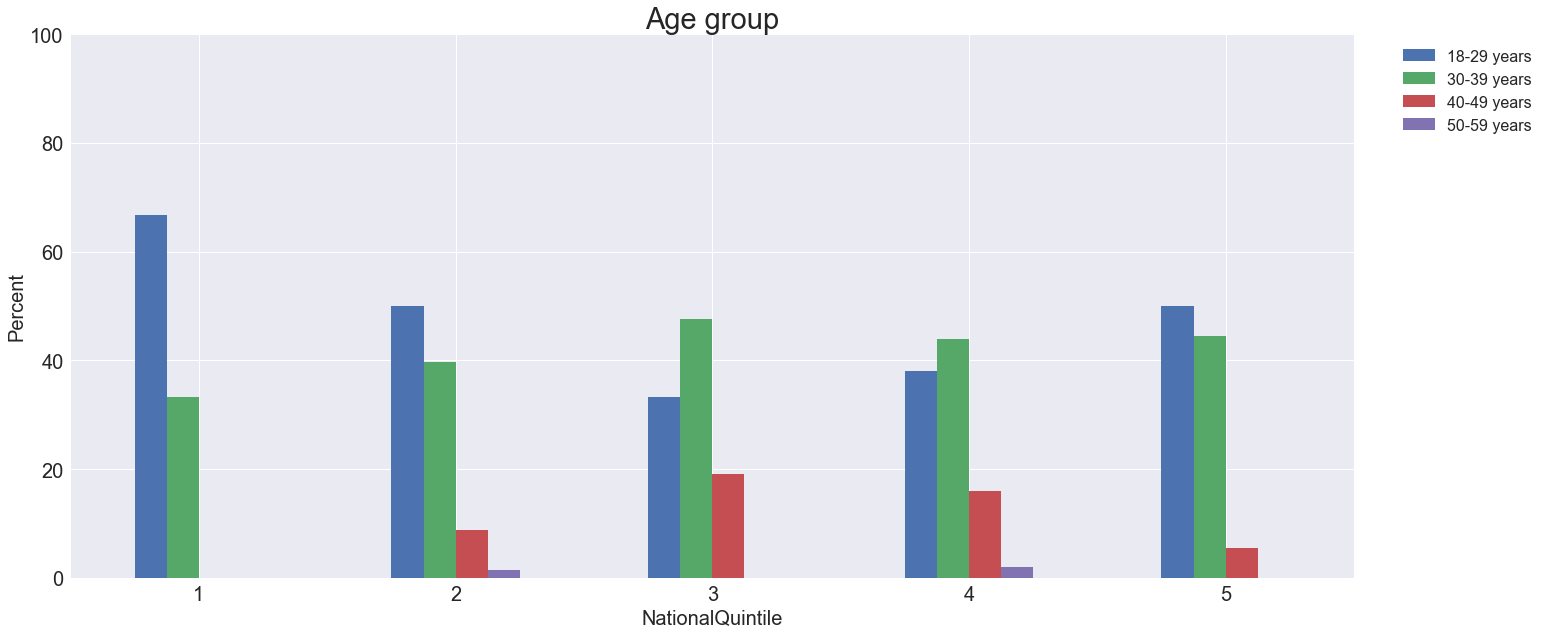

In [37]:
show_diff_for(df_Chanhomba_m, 'AgeGroup', 'Age group', [], (1.15, 1.0), group_by='NationalQuintile')

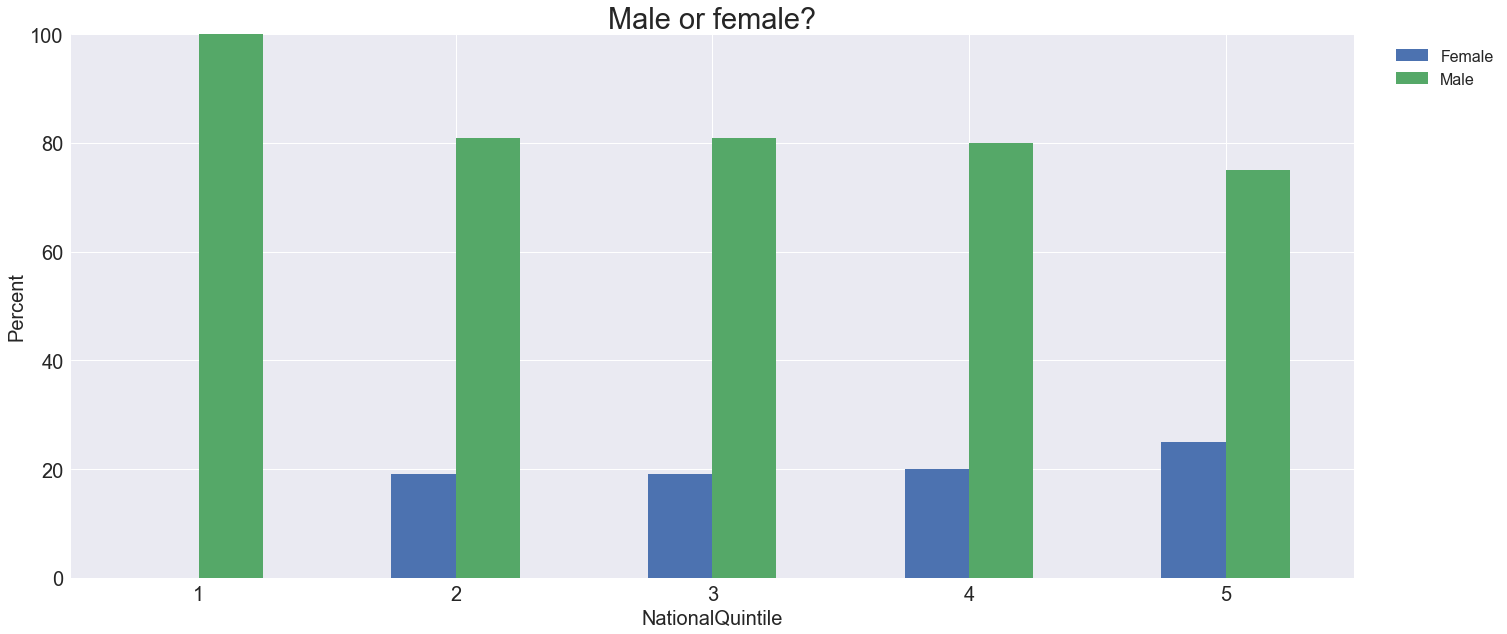

In [38]:
show_diff_for(df_Chanhomba_m, 'Gender', 'Male or female?', ['Female', 'Male'], (1.12, 1.0), group_by='NationalQuintile')

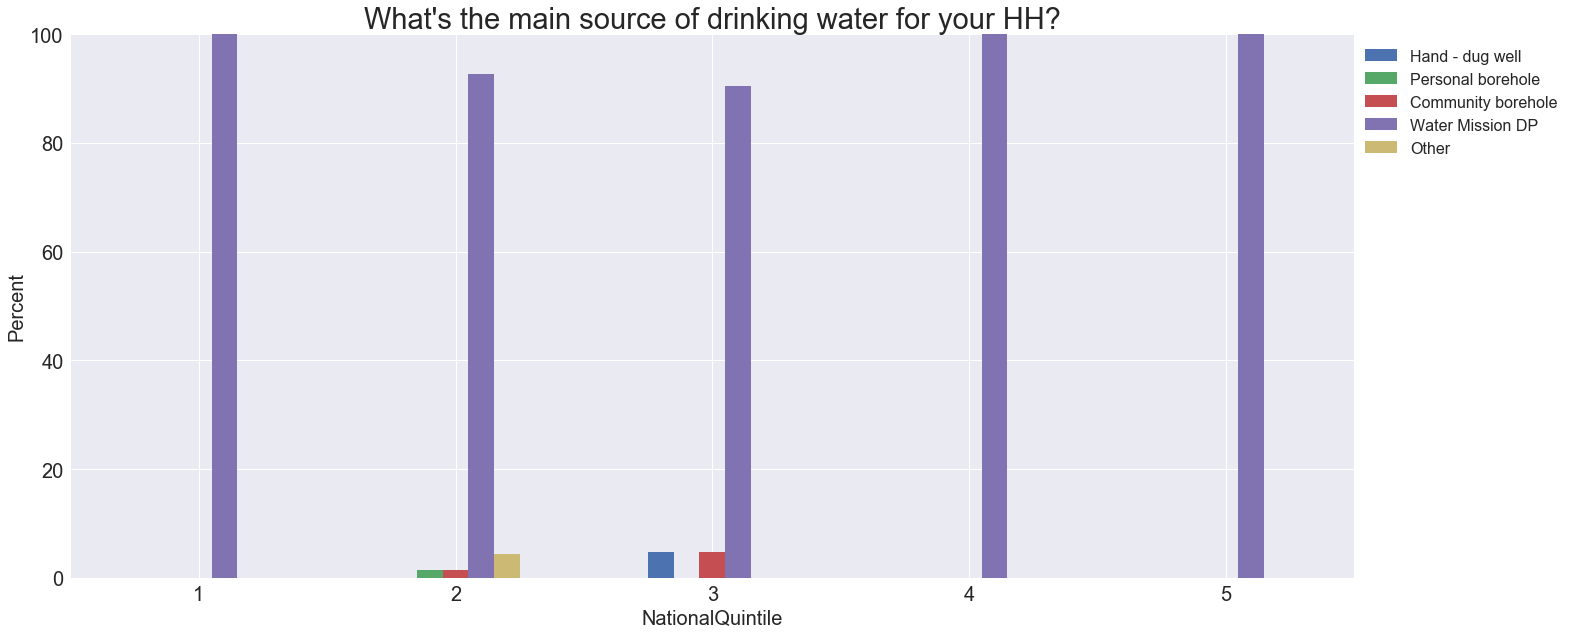

In [39]:
source_of_water =['Hand - dug well', 'Personal borehole', 'Community borehole', 'Water Mission DP', 'Other']
show_diff_for(df_Chanhomba_m, 'PrimarySource', "What's the main source of drinking water for your HH?", source_of_water, (1.17, 1.0), group_by='NationalQuintile')


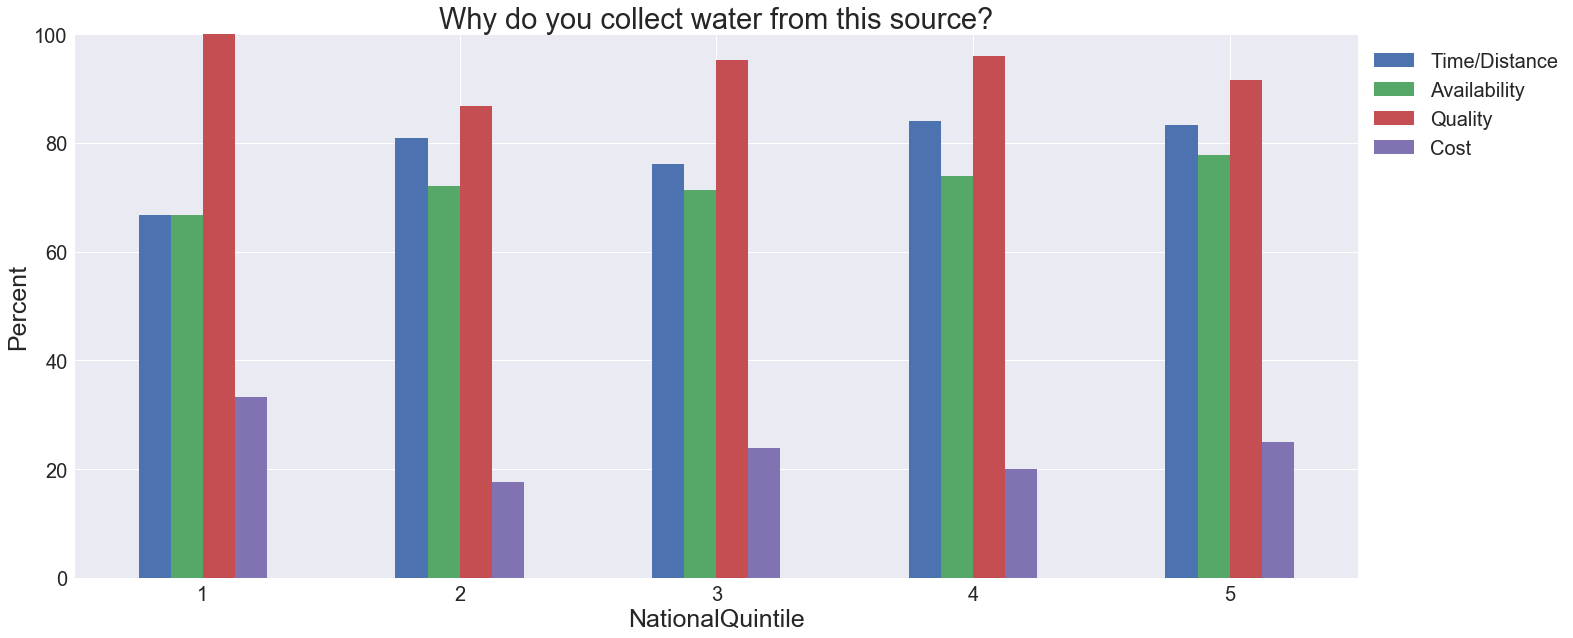

In [40]:
count_agg = {'Count': {'': 'sum'}}
show_reasons_diff_2(df_Chanhomba_m, {'Reason/Cost': 'Cost', 'Reason/Availability': 'Availability', 
                                     'Reason/Time_Distance': 'Time/Distance', 'Reason/Quality': 'Quality'}, 
                    count_agg, title='Why do you collect water from this source?',
                    group_by='NationalQuintile', bbbox_to_anchor=(1.17, 1) ) 

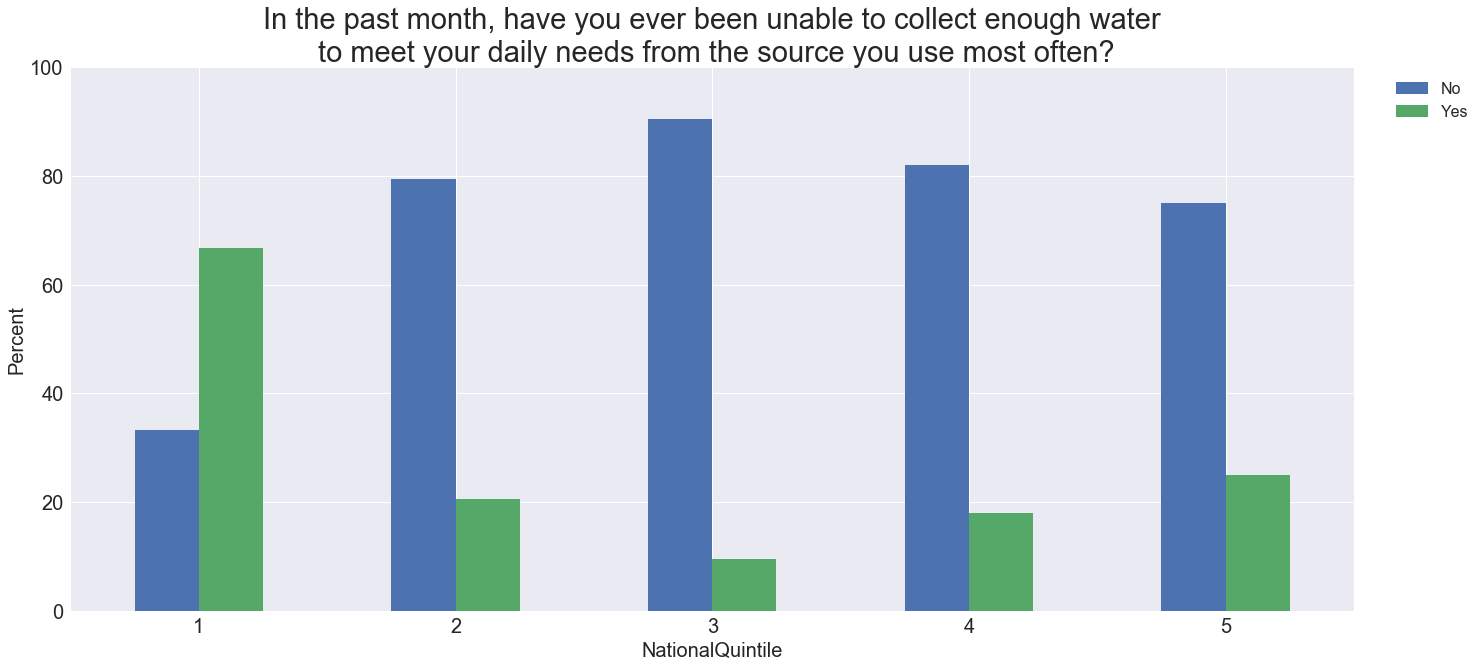

In [41]:
show_diff_for(df_Chanhomba_m, 'WaterAvailability', 'In the past month, have you ever been unable to collect enough water\n to meet your daily needs from the source you use most often?',
              ['No', 'Yes'], (1.1, 1.0), group_by='NationalQuintile')

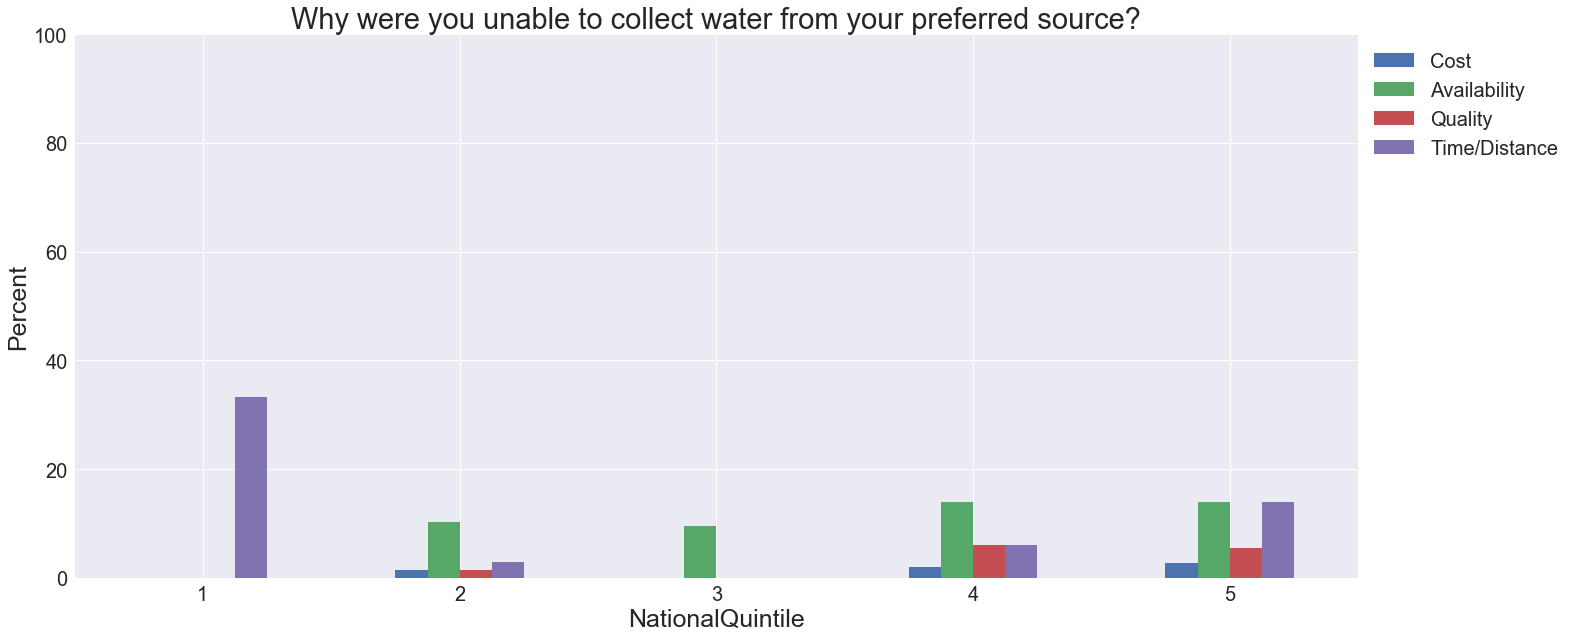

In [42]:
count_agg = {'Count': {'': 'sum'}}
show_reasons_diff_2(df_Chanhomba_m, {'AvailReason/Cost': 'Cost', 'AvailReason/Availability': 'Availability', 
                                     'AvailReason/Time_Distance': 'Time/Distance', 'AvailReason/Quality': 'Quality'}, 
                    count_agg, title='Why were you unable to collect water from your preferred source?',
                    group_by='NationalQuintile', bbbox_to_anchor=(1.17, 1) ) 

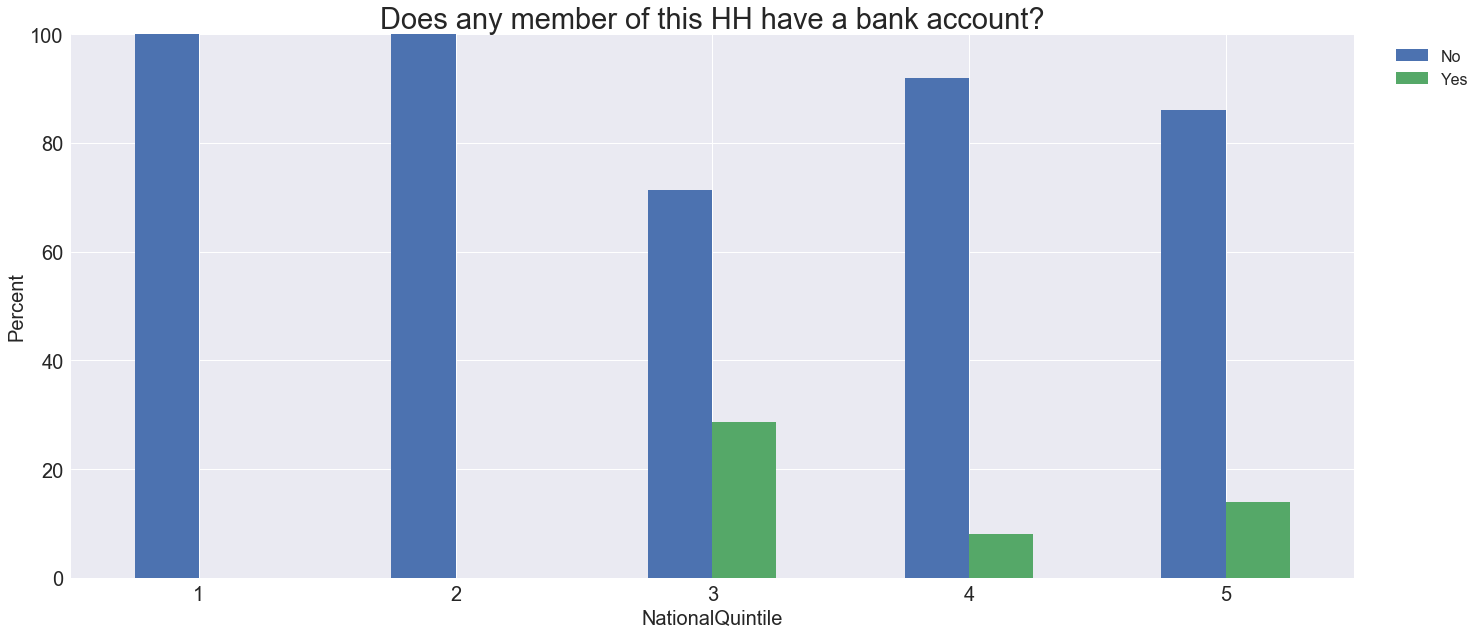

In [43]:
show_diff_for(df_Chanhomba_m, 'BankAccount', 'Does any member of this HH have a bank account?', ['No', 'Yes'], (1.1, 1.0), group_by='NationalQuintile')

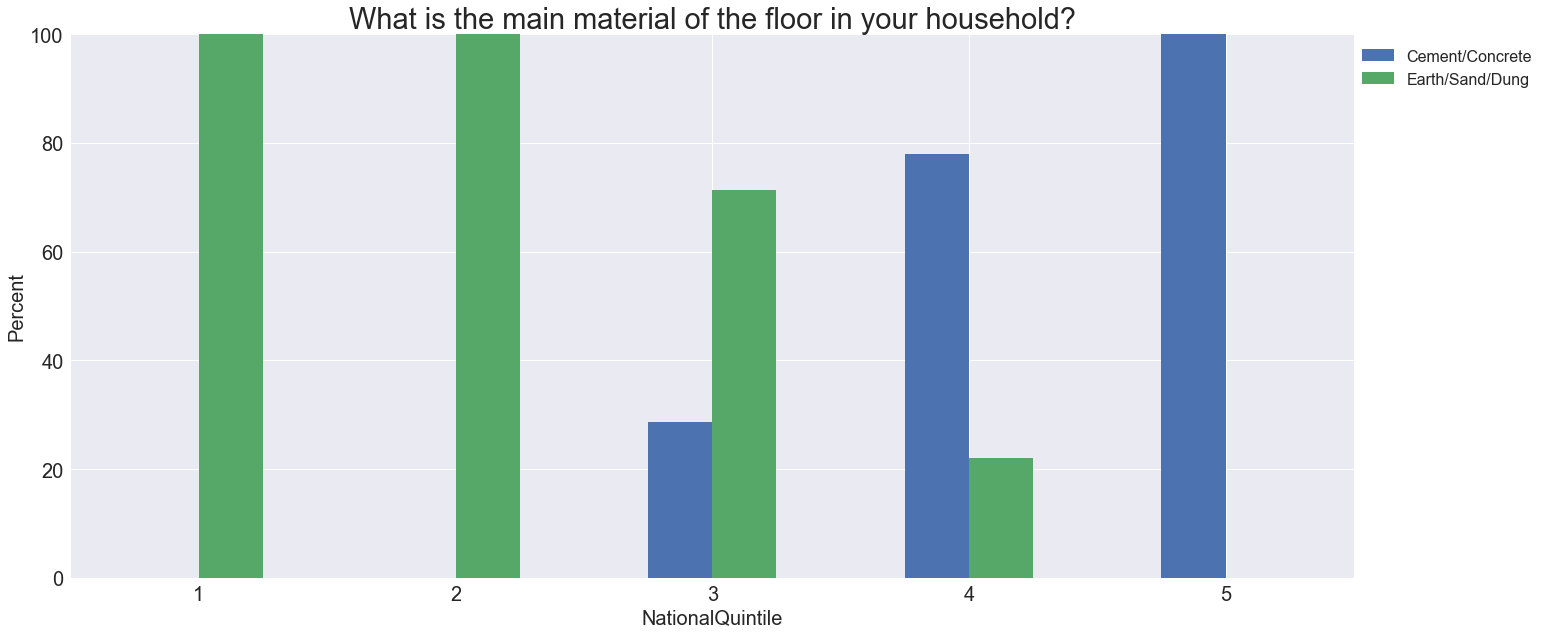

In [44]:
show_diff_for(df_Chanhomba_m, 'FloorMaterial', 'What is the main material of the floor in your household?',
              ['Cement/Concrete', 'Earth/Sand/Dung'], (1.15, 1.0), group_by='NationalQuintile')

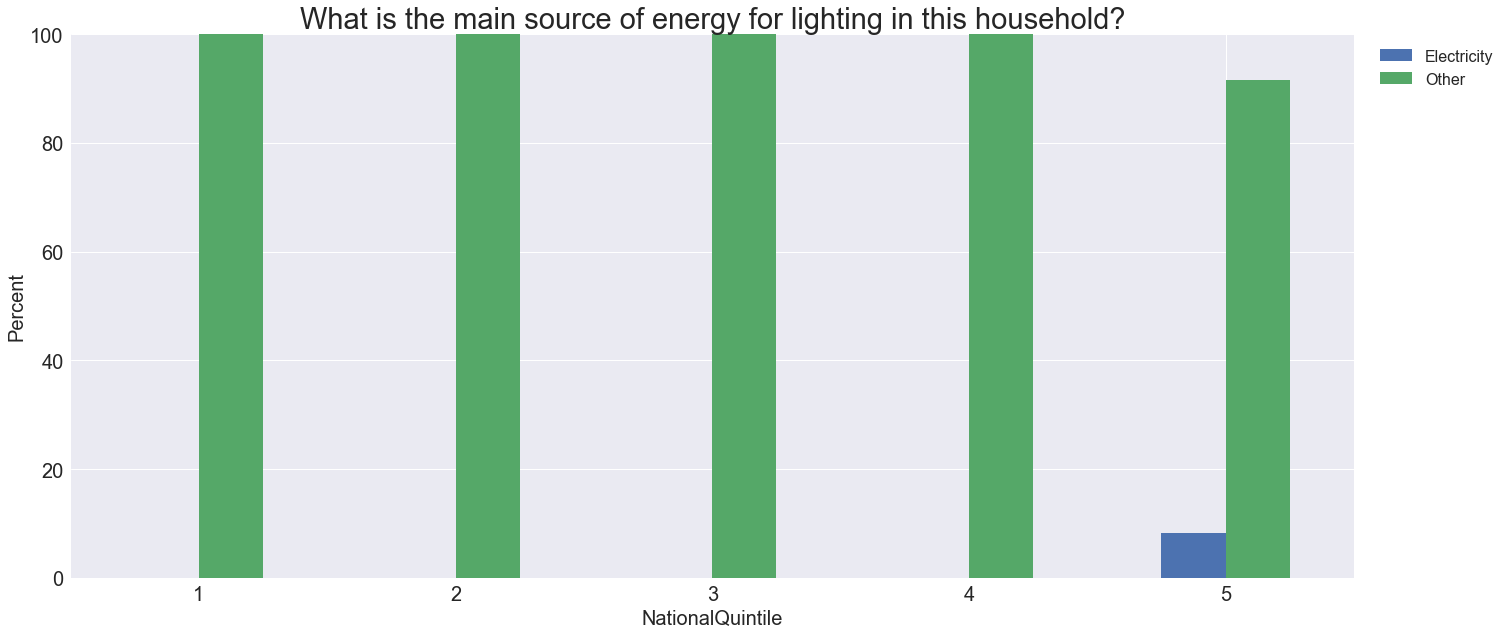

In [45]:
show_diff_for(df_Chanhomba_m, 'SourceOfLighting', 
              'What is the main source of energy for lighting in this household?', 
              ['Electricity', 'Other'], (1.12, 1.0), group_by='NationalQuintile')

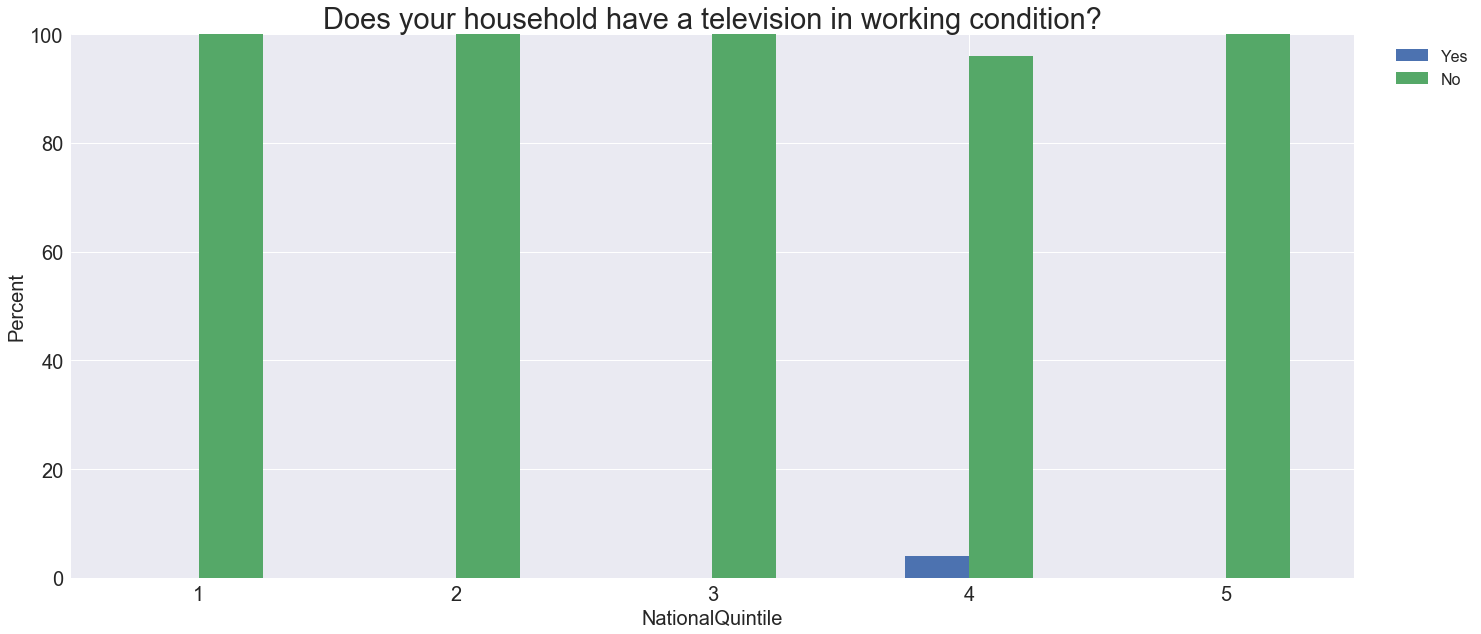

In [46]:
show_diff_for(df_Chanhomba_m, 'TVSet', 
              'Does your household have a television in working condition?', 
              ['Yes', 'No'], (1.1, 1.0), group_by='NationalQuintile')

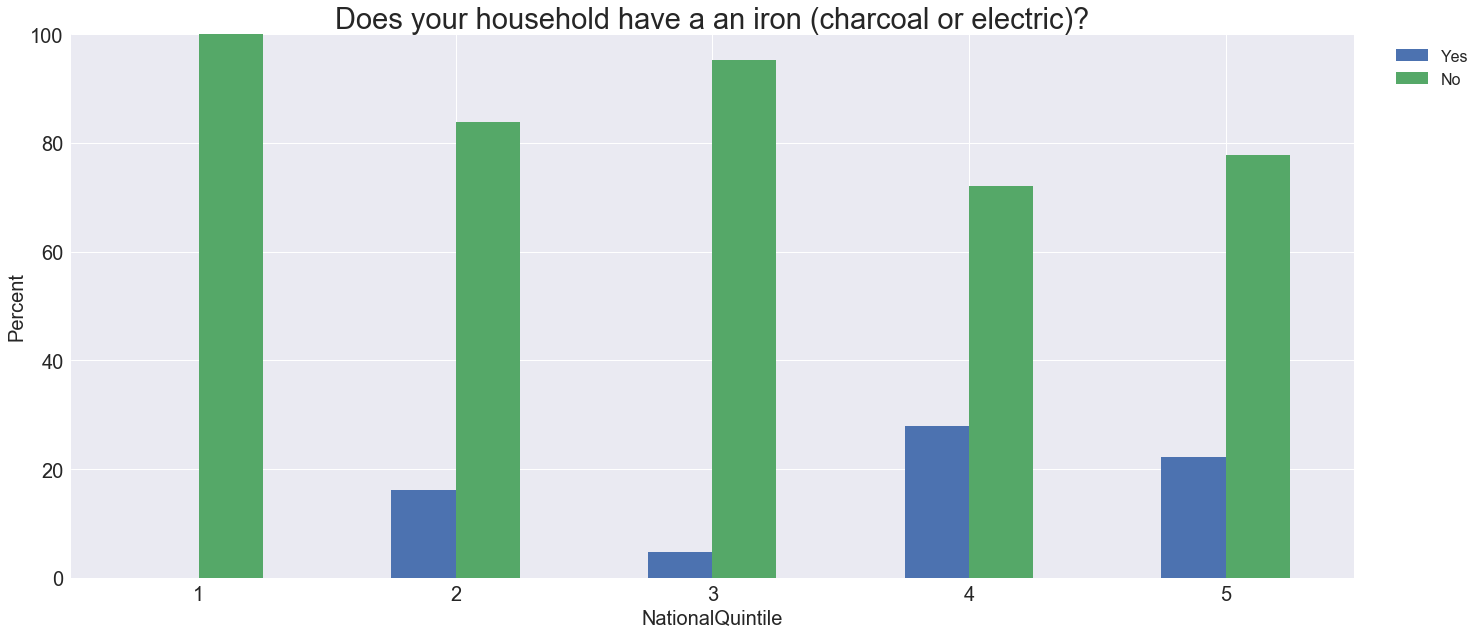

In [47]:
show_diff_for(df_Chanhomba_m, 'Iron', 
              'Does your household have a an iron (charcoal or electric)?', 
              ['Yes', 'No'], (1.1, 1.0), group_by='NationalQuintile')

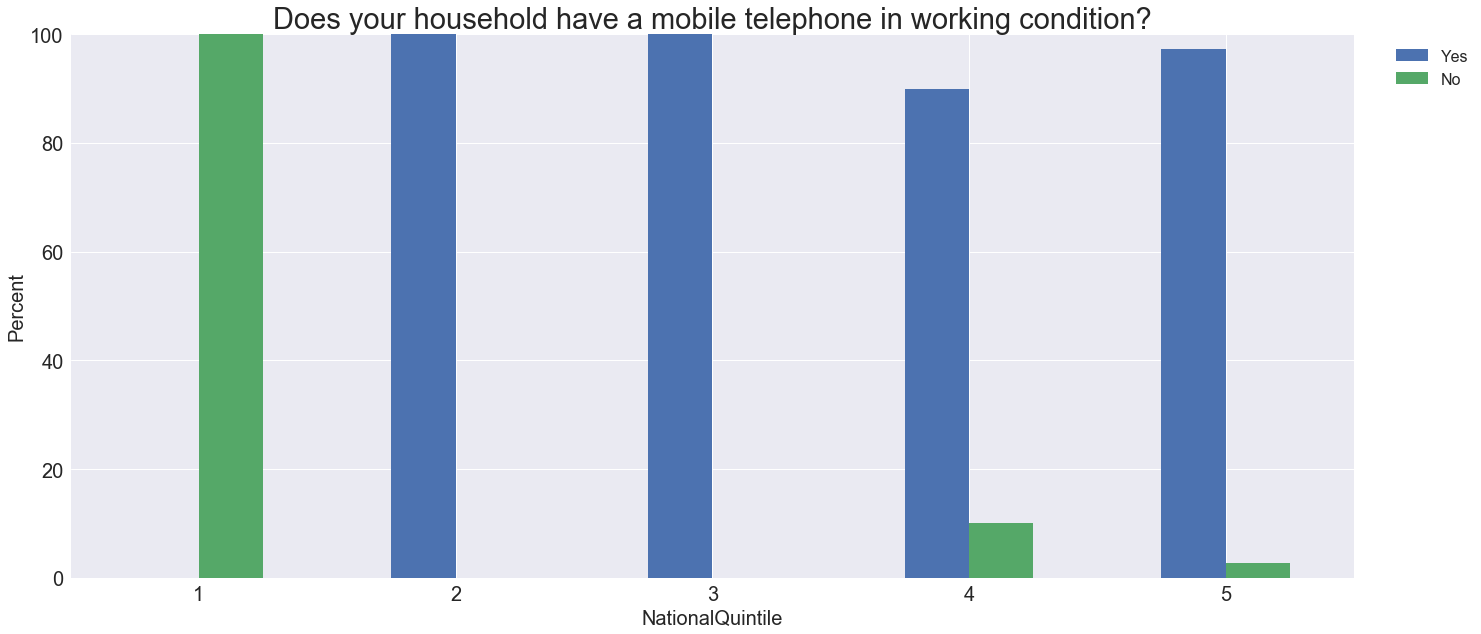

In [48]:
show_diff_for(df_Chanhomba_m, 'MobilePhone', 
              'Does your household have a mobile telephone in working condition?', 
              ['Yes', 'No'], (1.1, 1.0), group_by='NationalQuintile')

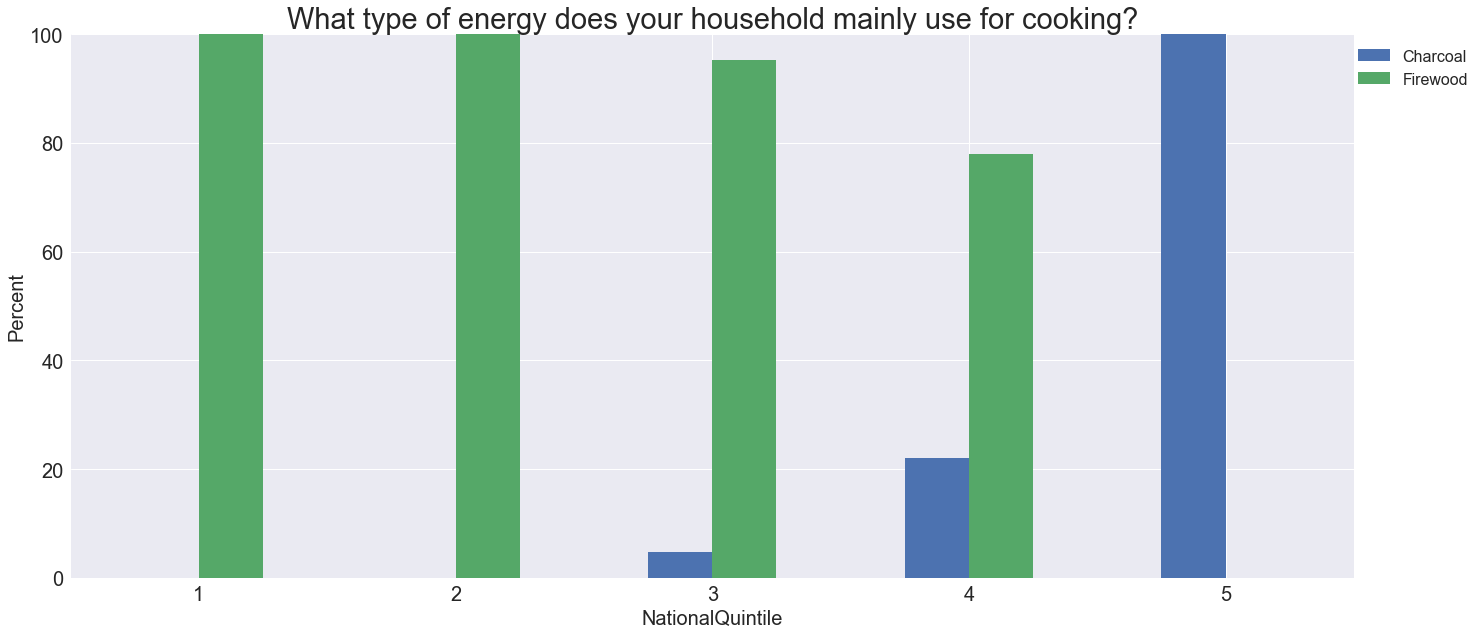

In [49]:
show_diff_for(df_Chanhomba_m, 'EnergyForCooking', 
              'What type of energy does your household mainly use for cooking?', 
              ['Charcoal', 'Firewood'], (1.1, 1.0), group_by='NationalQuintile')

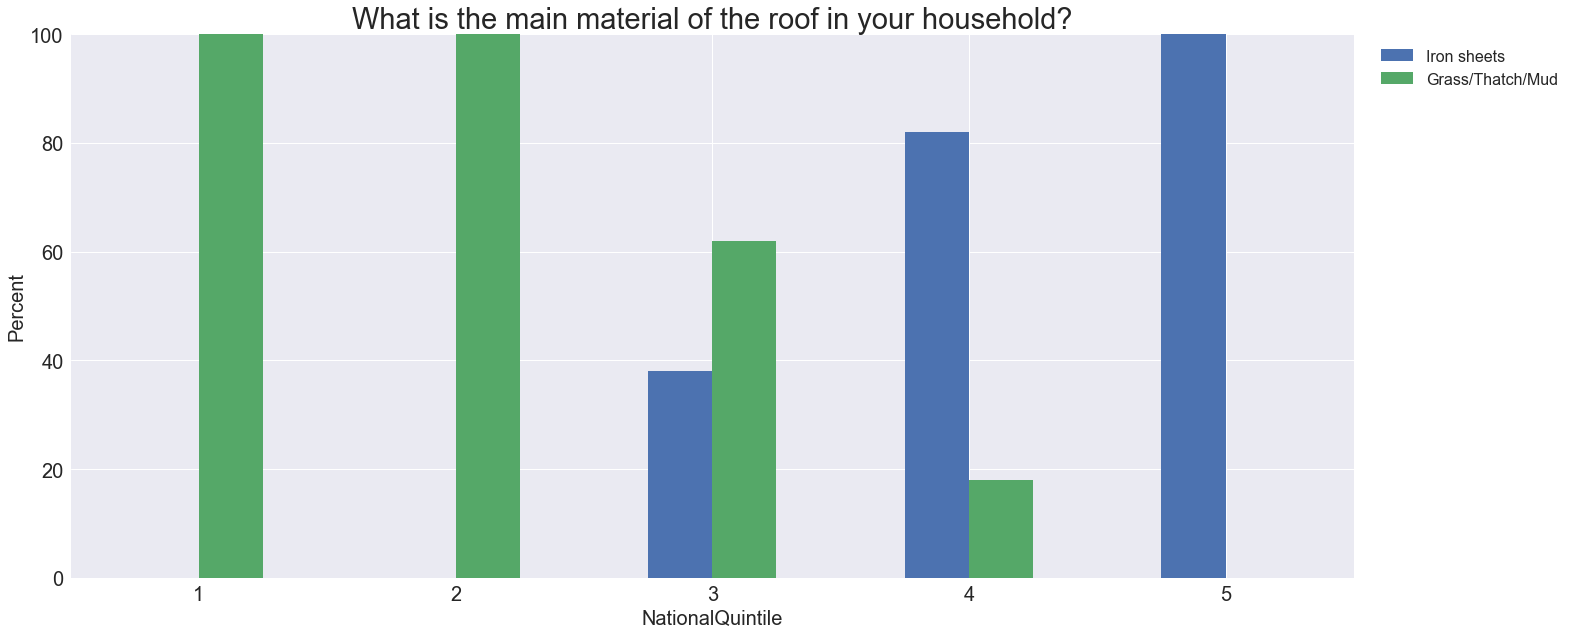

In [50]:
show_diff_for(df_Chanhomba_m, 'RoofMaterial', 
              'What is the main material of the roof in your household?', 
              ['Iron sheets', 'Grass/Thatch/Mud'], (1.17, 1.0), group_by='NationalQuintile')

<a id='gidewari'></a>
## Gidewari

Show number of respondents, water consumption and money expenditure on water for each group in the dataset that came from Gidewari

In [51]:
get_group_measurements_quintile(df_Gidewari_m)

,AmountOfWater,WaterExpenditure,Count
,Average value,Average value,Respondents
NationalQuintile,,,
1,44.00,2940.00,4
2,51.76,2022.55,51
3,83.12,2617.31,26
4,40.45,2528.00,20
5,53.25,3682.50,4


In [52]:
df_Gidewari_m = df_Gidewari_m.assign(AgeGroup = df_Gidewari_m.Age.apply(lambda a: get_age_group(a)))

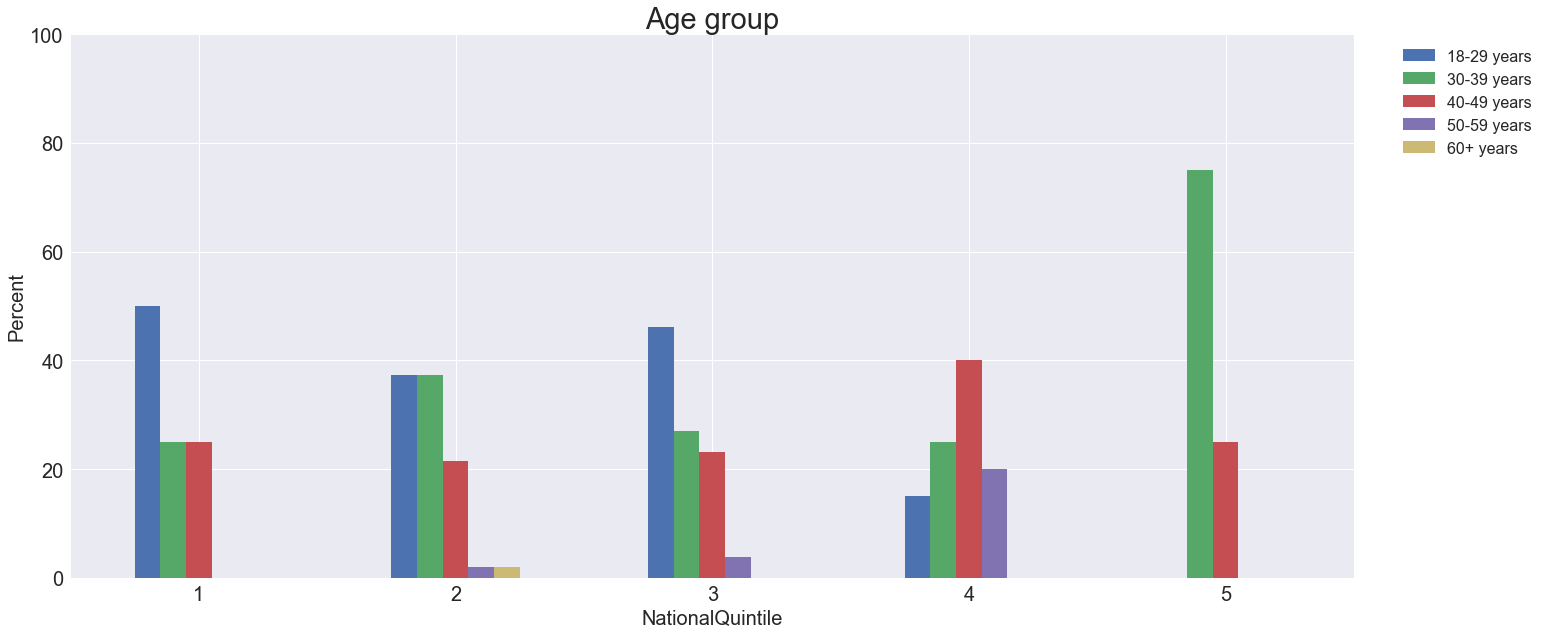

In [53]:
show_diff_for(df_Gidewari_m, 'AgeGroup', 'Age group', [], (1.15, 1.0), group_by='NationalQuintile')

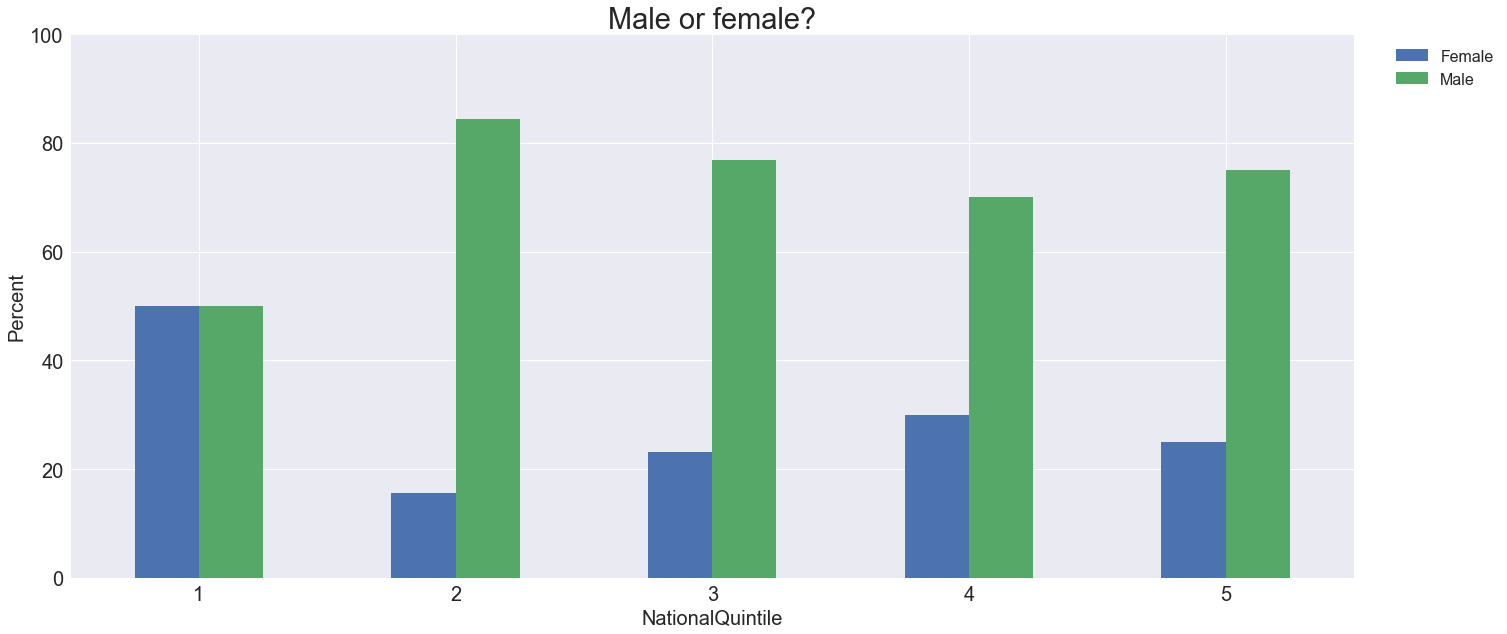

In [54]:
show_diff_for(df_Gidewari_m, 'Gender', 'Male or female?', ['Female', 'Male'], (1.12, 1.0), group_by='NationalQuintile')

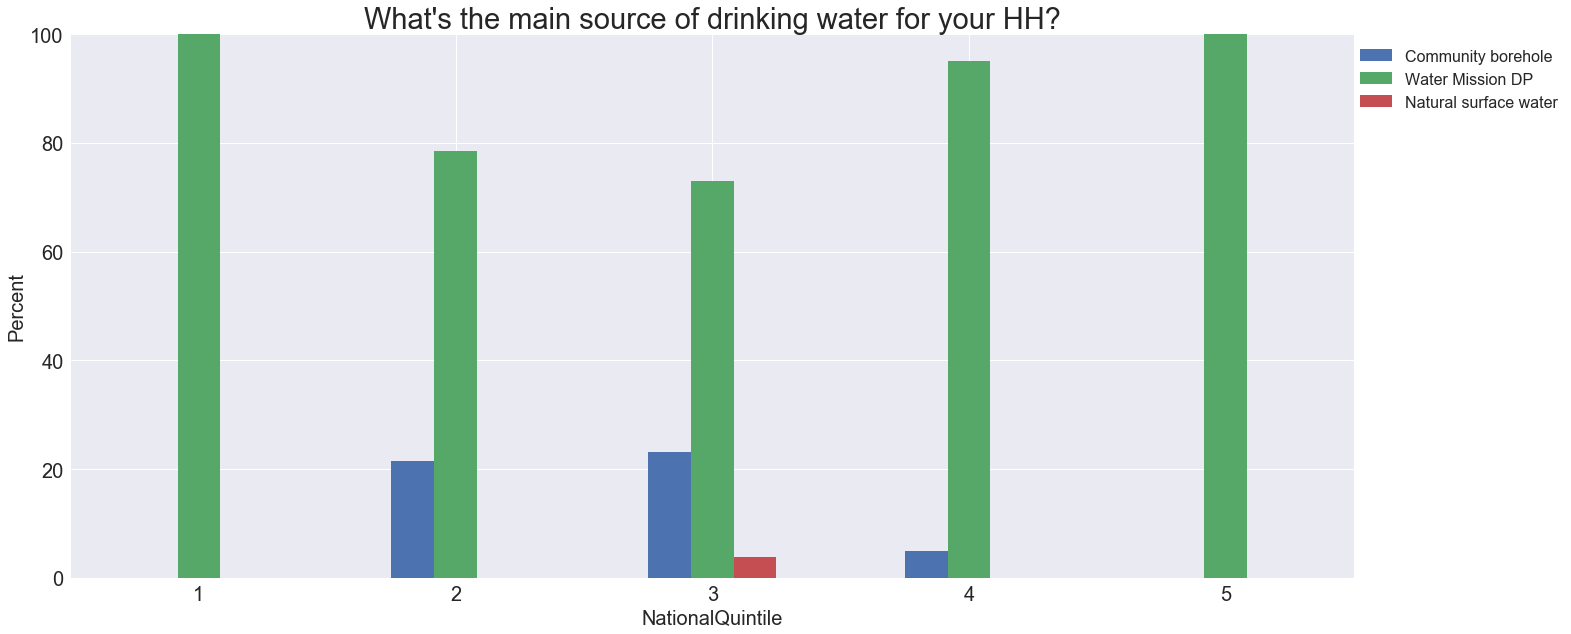

In [55]:
source_of_water =['Community borehole',  'Water Mission DP', 'Natural surface water']
show_diff_for(df_Gidewari_m, 'PrimarySource', "What's the main source of drinking water for your HH?", source_of_water, (1.17, 1.0), group_by='NationalQuintile')

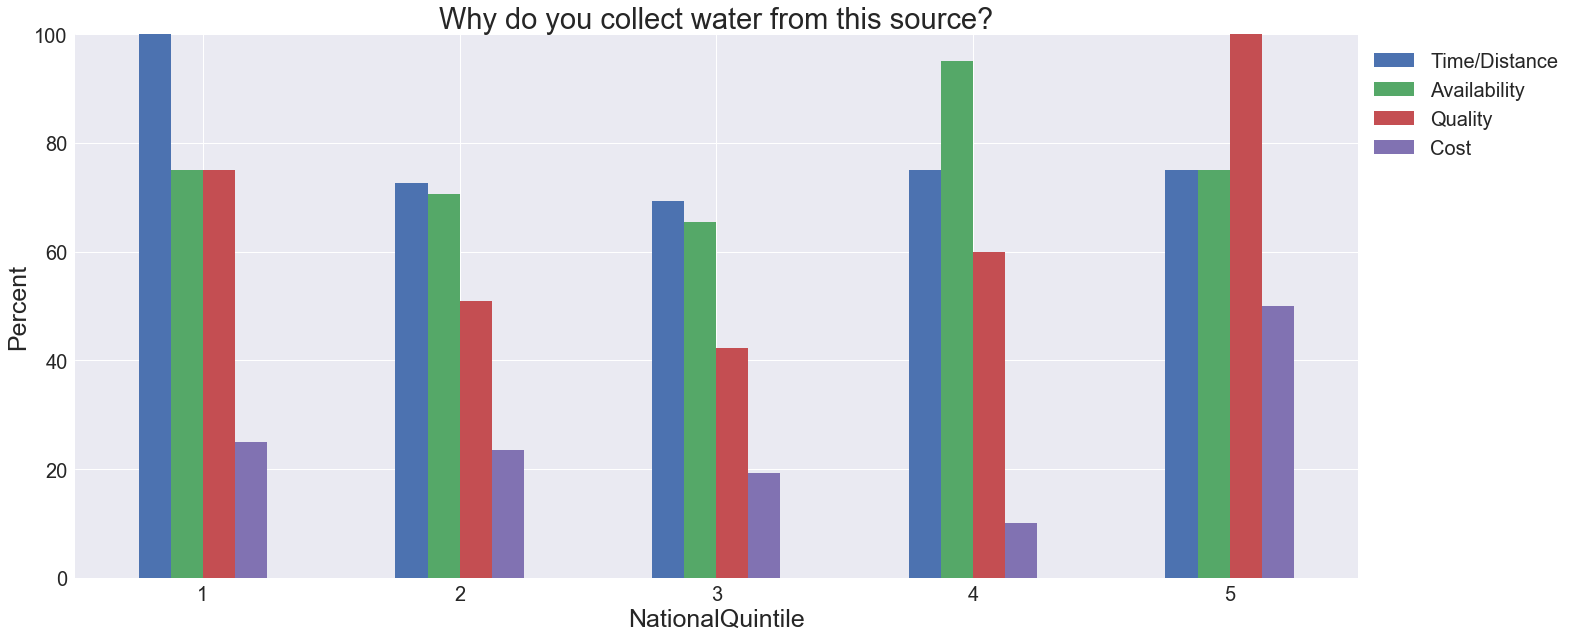

In [56]:
count_agg = {'Count': {'': 'sum'}}
show_reasons_diff_2(df_Gidewari_m, {'Reason/Cost': 'Cost', 'Reason/Availability': 'Availability', 
                                     'Reason/Time_Distance': 'Time/Distance', 'Reason/Quality': 'Quality'}, 
                    count_agg, title='Why do you collect water from this source?',
                    group_by='NationalQuintile', bbbox_to_anchor=(1.17, 1) ) 

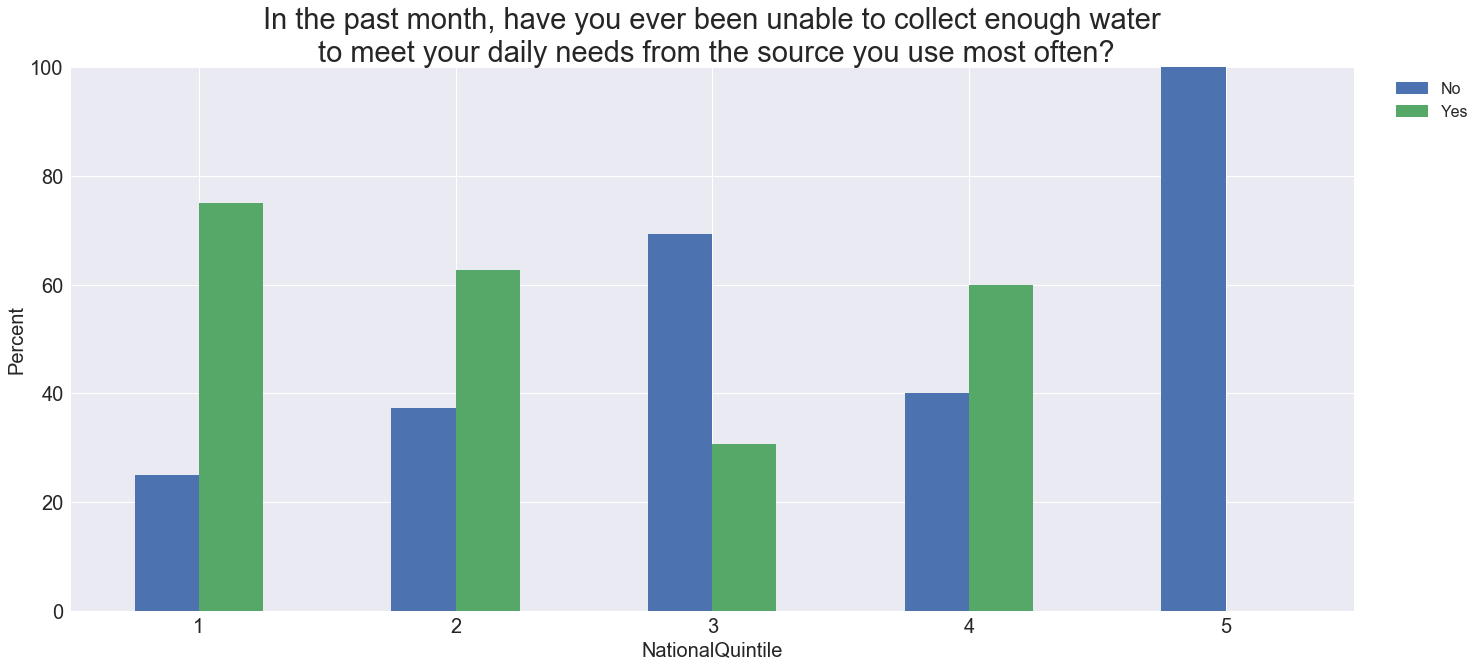

In [57]:
show_diff_for(df_Gidewari_m, 'WaterAvailability', 'In the past month, have you ever been unable to collect enough water\n to meet your daily needs from the source you use most often?',
              ['No', 'Yes'], (1.1, 1.0), group_by='NationalQuintile')

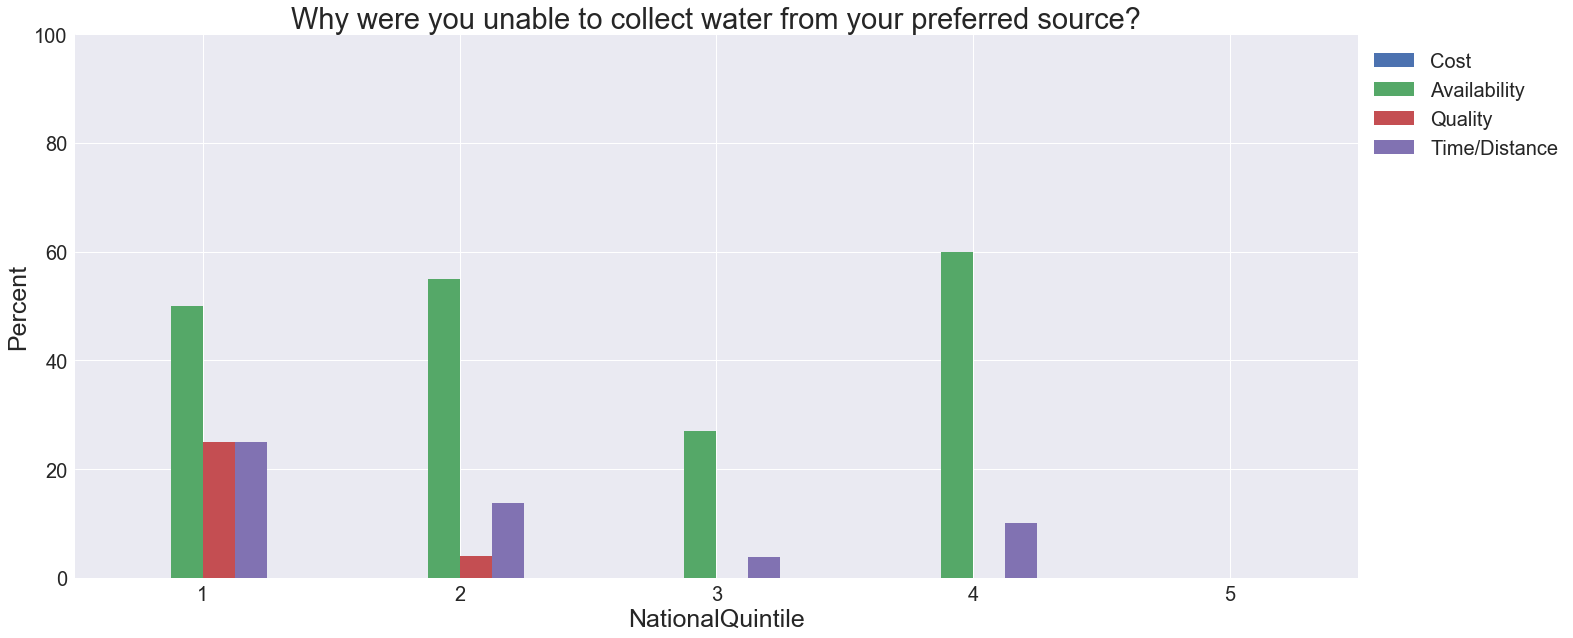

In [58]:
count_agg = {'Count': {'': 'sum'}}
show_reasons_diff_2(df_Gidewari_m, {'AvailReason/Cost': 'Cost', 'AvailReason/Availability': 'Availability', 
                                     'AvailReason/Time_Distance': 'Time/Distance', 'AvailReason/Quality': 'Quality'}, 
                    count_agg, title='Why were you unable to collect water from your preferred source?',
                    group_by='NationalQuintile', bbbox_to_anchor=(1.17, 1) ) 

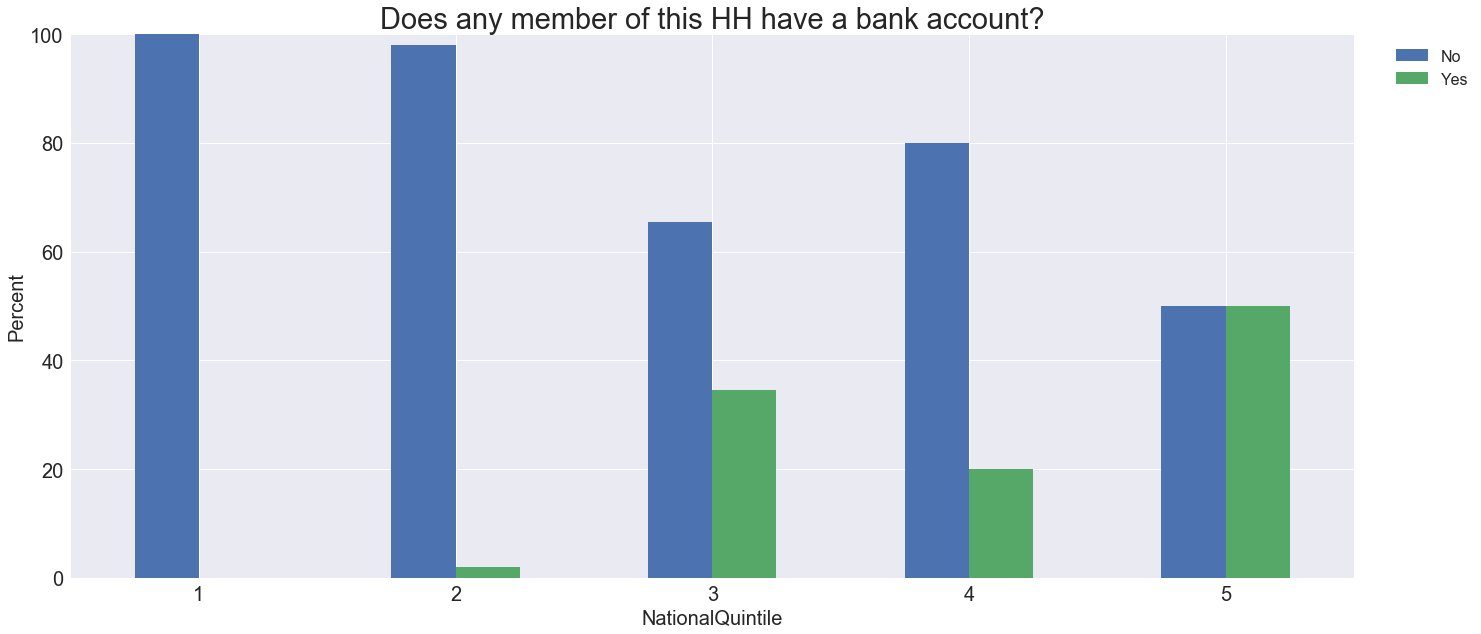

In [59]:
show_diff_for(df_Gidewari_m, 'BankAccount', 'Does any member of this HH have a bank account?', ['No', 'Yes'], (1.1, 1.0), group_by='NationalQuintile')

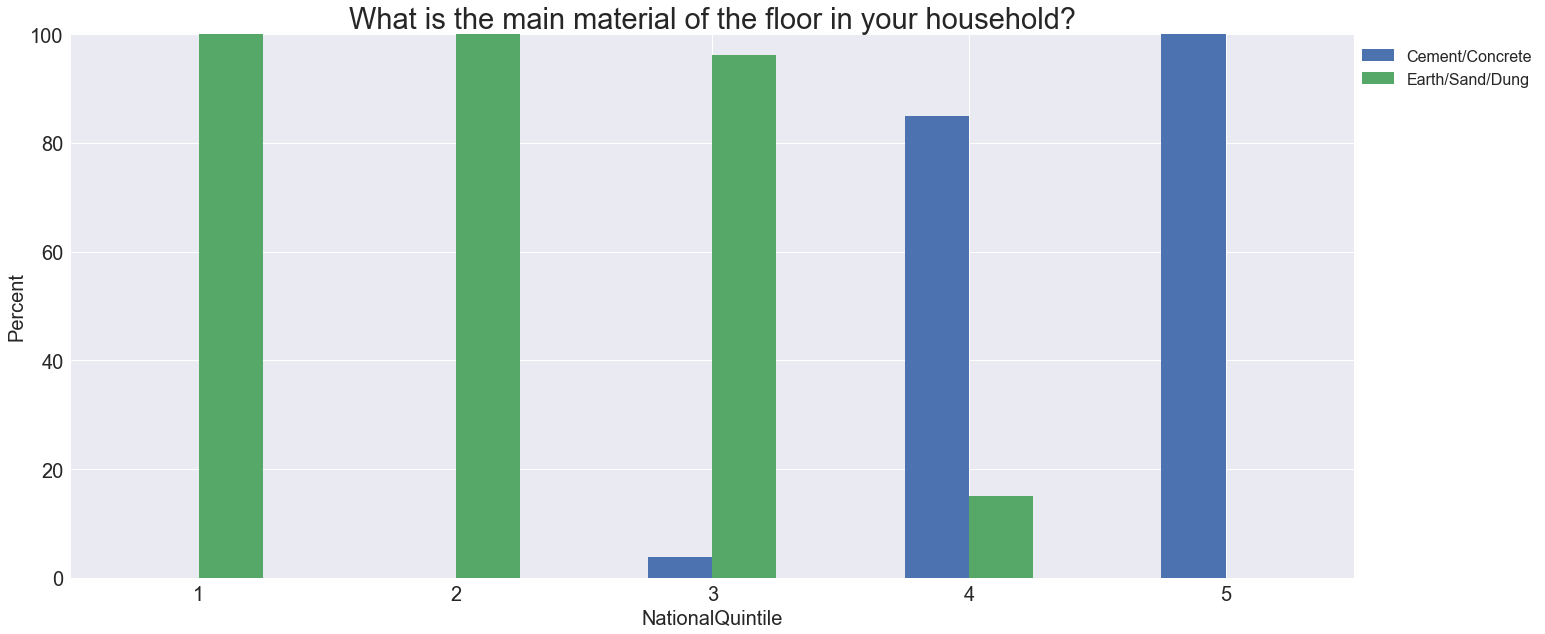

In [60]:
show_diff_for(df_Gidewari_m, 'FloorMaterial', 'What is the main material of the floor in your household?',
              ['Cement/Concrete', 'Earth/Sand/Dung'], (1.15, 1.0), group_by='NationalQuintile')

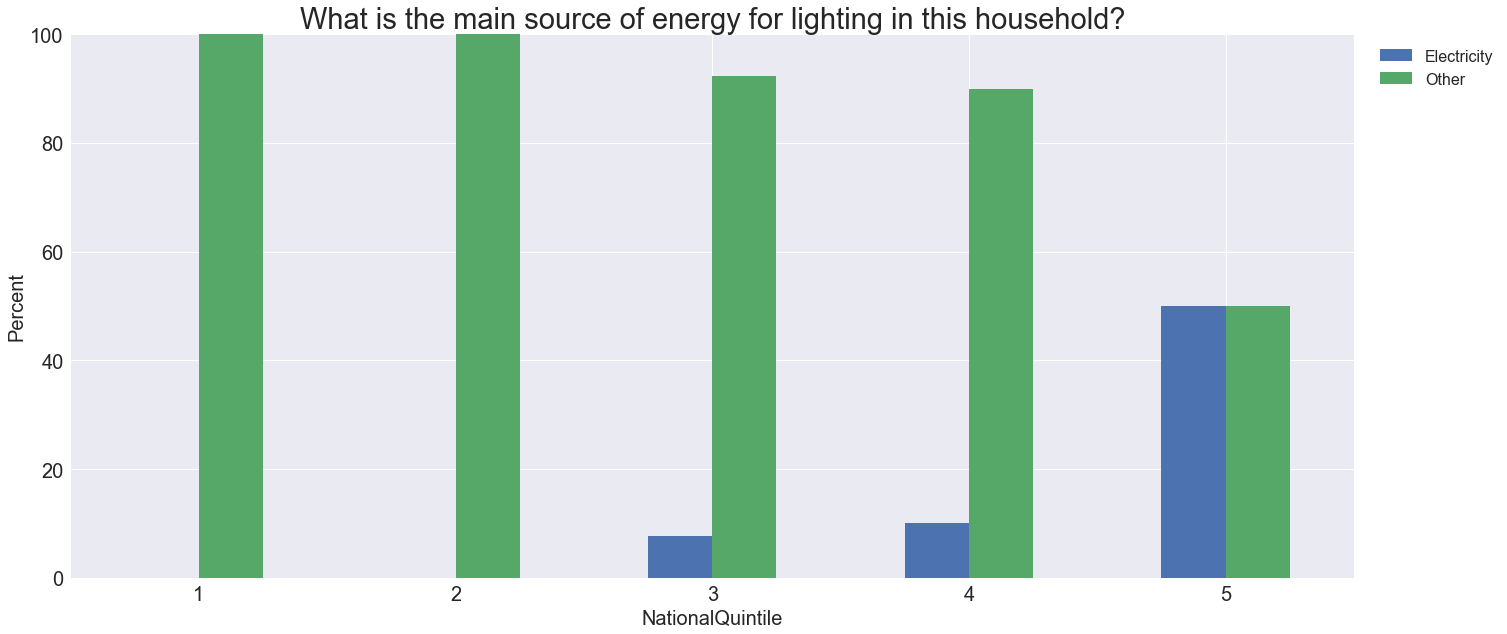

In [61]:
show_diff_for(df_Gidewari_m, 'SourceOfLighting', 
              'What is the main source of energy for lighting in this household?', 
              ['Electricity', 'Other'], (1.12, 1.0), group_by='NationalQuintile')

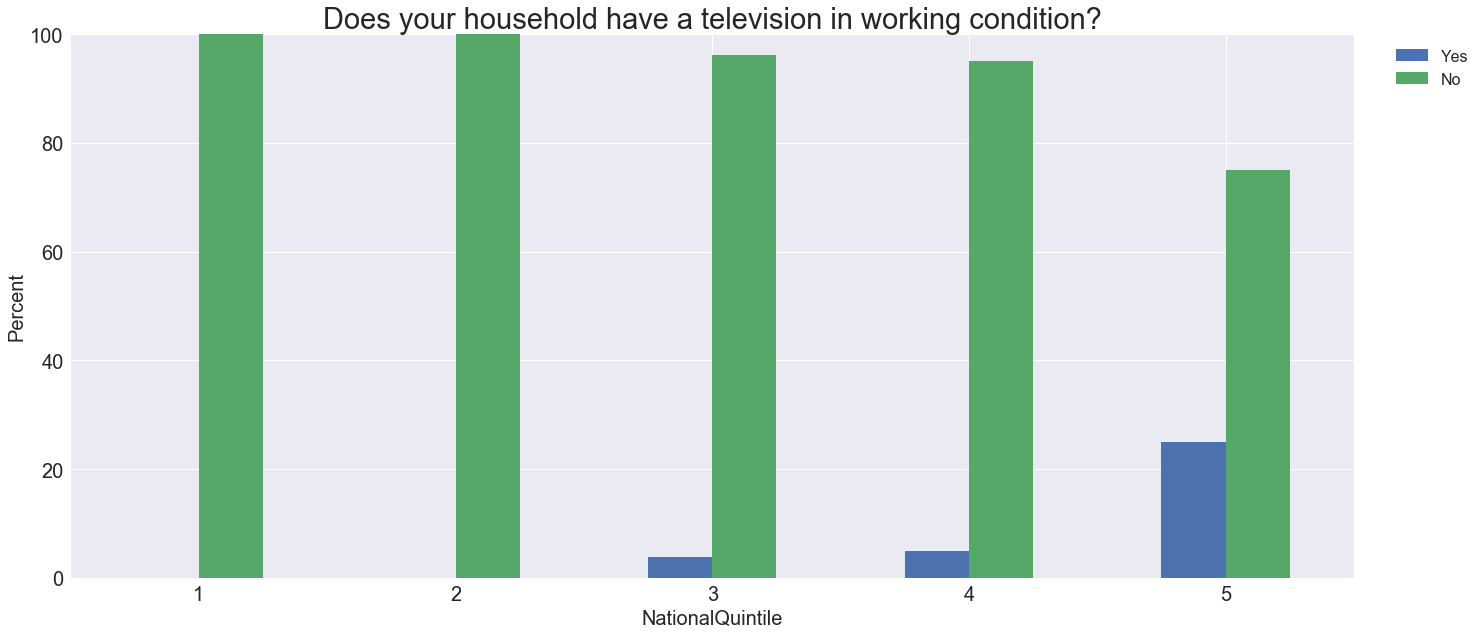

In [62]:
show_diff_for(df_Gidewari_m, 'TVSet', 
              'Does your household have a television in working condition?', 
              ['Yes', 'No'], (1.1, 1.0), group_by='NationalQuintile')
              

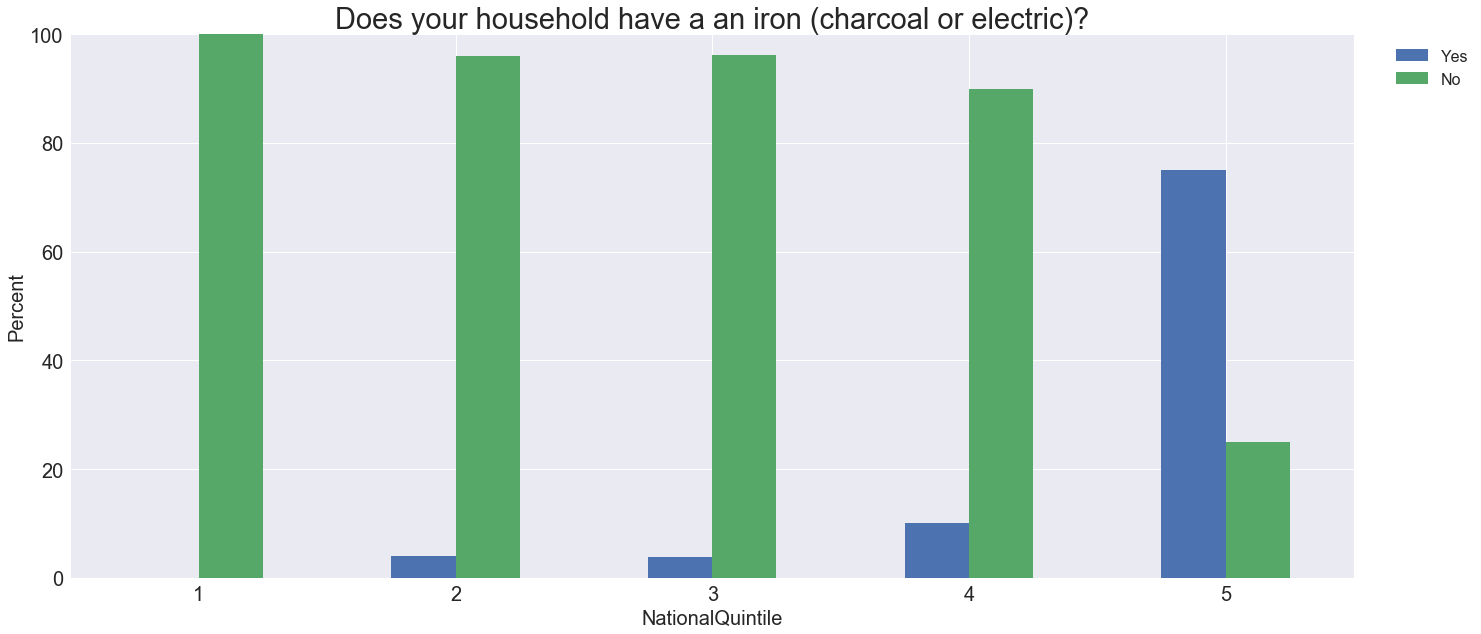

In [63]:
show_diff_for(df_Gidewari_m, 'Iron', 
              'Does your household have a an iron (charcoal or electric)?', 
              ['Yes', 'No'], (1.1, 1.0), group_by='NationalQuintile')

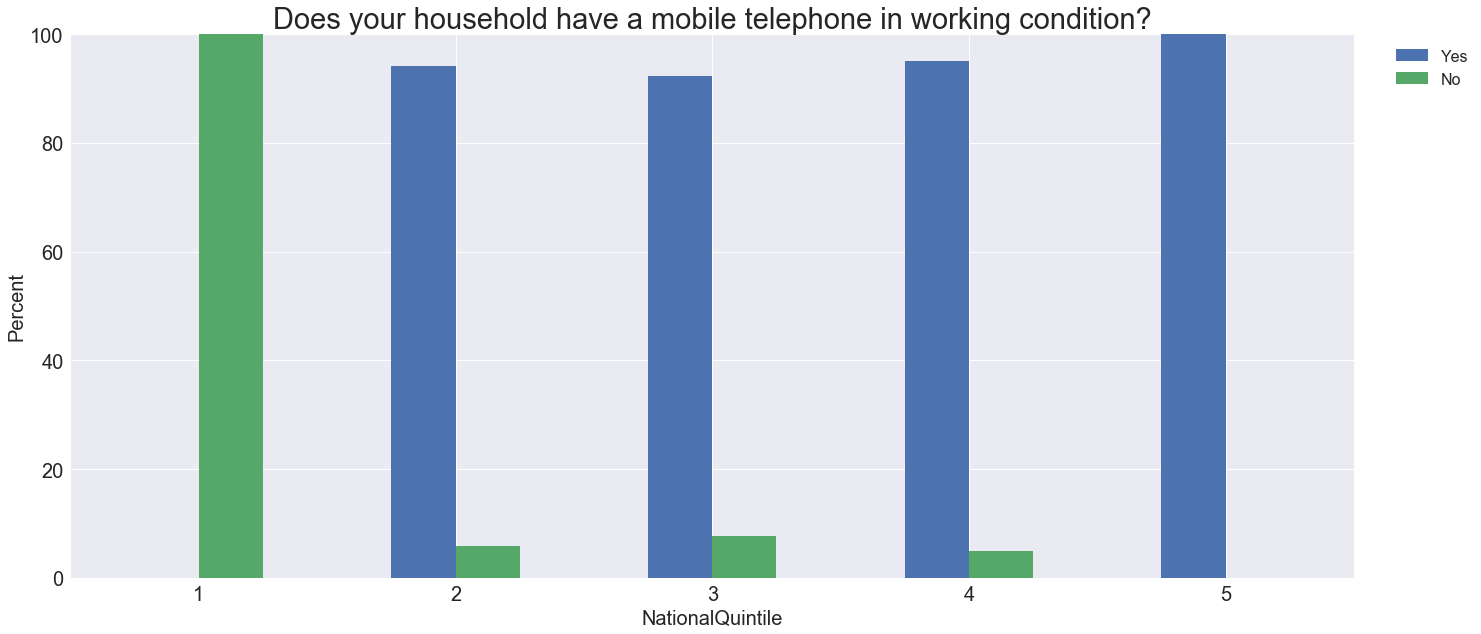

In [64]:
show_diff_for(df_Gidewari_m, 'MobilePhone', 
              'Does your household have a mobile telephone in working condition?', 
              ['Yes', 'No'], (1.1, 1.0), group_by='NationalQuintile')

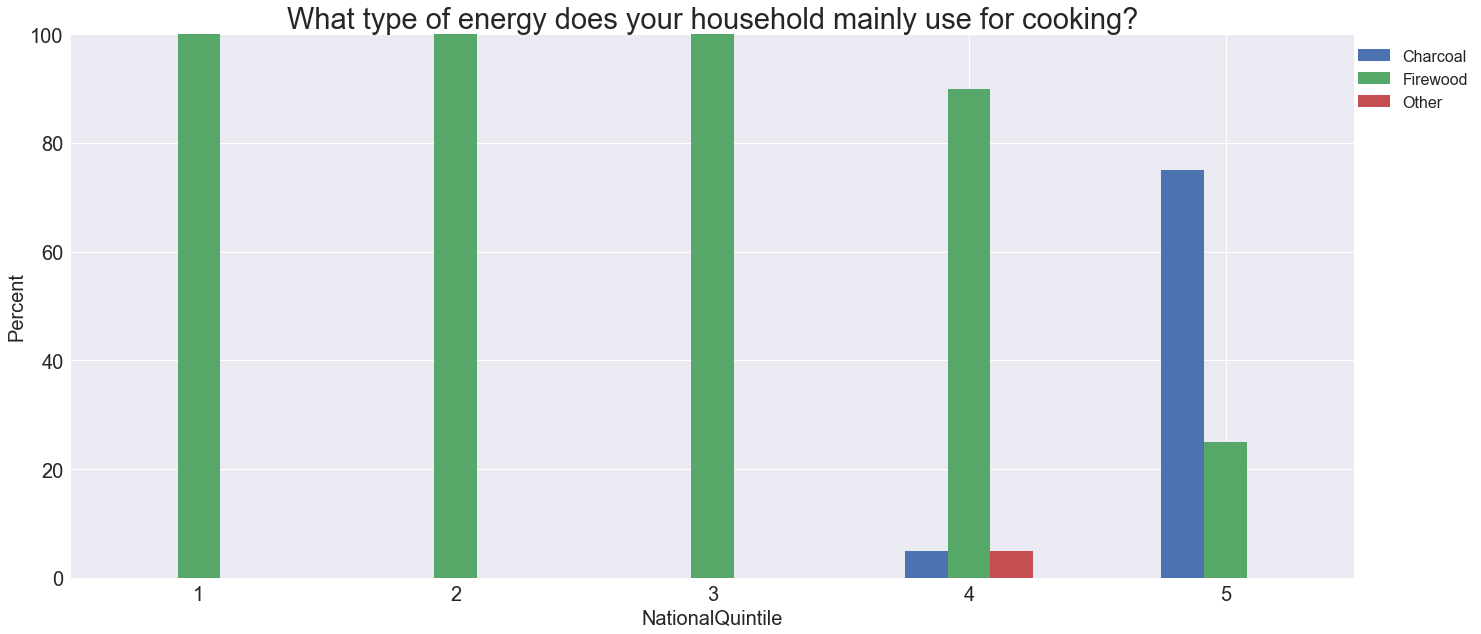

In [65]:
show_diff_for(df_Gidewari_m, 'EnergyForCooking', 
              'What type of energy does your household mainly use for cooking?', 
              ['Charcoal', 'Firewood', 'Other'], (1.1, 1.0), group_by='NationalQuintile')

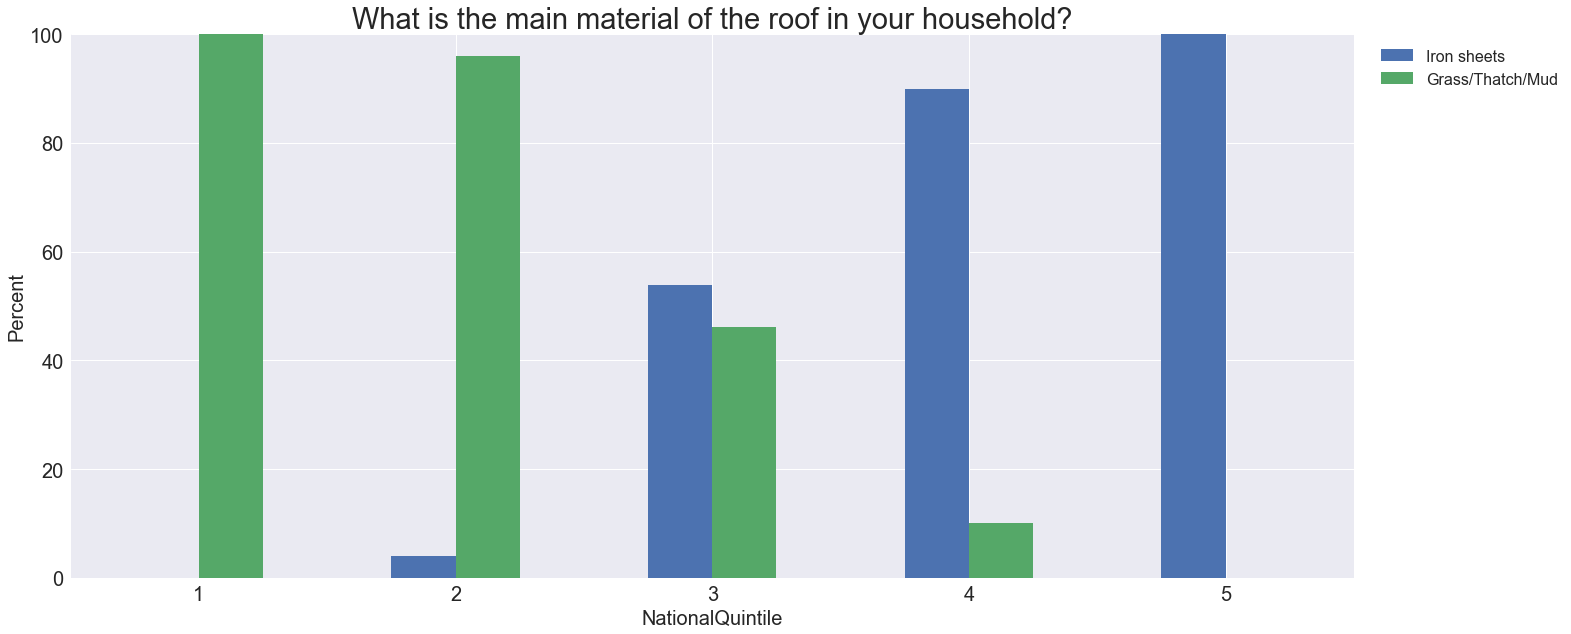

In [66]:
show_diff_for(df_Gidewari_m, 'RoofMaterial', 
              'What is the main material of the roof in your household?', 
              ['Iron sheets', 'Grass/Thatch/Mud'], (1.17, 1.0), group_by='NationalQuintile')

<a id='compare_communities'></a>
## Comparison of the groups between the rural communities

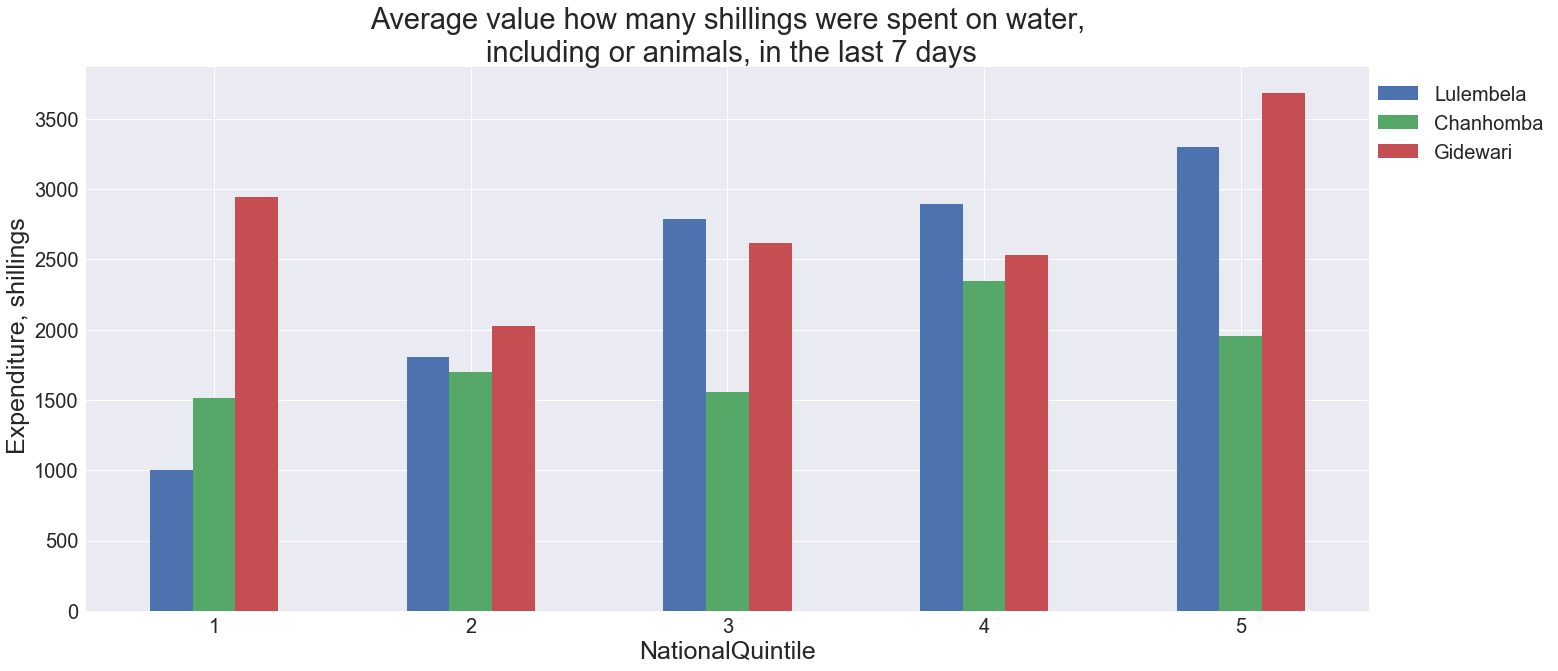

In [67]:
show_diff_between_3_communities_nq(df_Lulembela_m, df_Chanhomba_m, df_Gidewari_m,
                                   'WaterExpenditure', 'mean', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                   'Average value how many shillings were spent on water,\n including or animals, in the last 7 days',
                                   ' Expenditure, shillings')

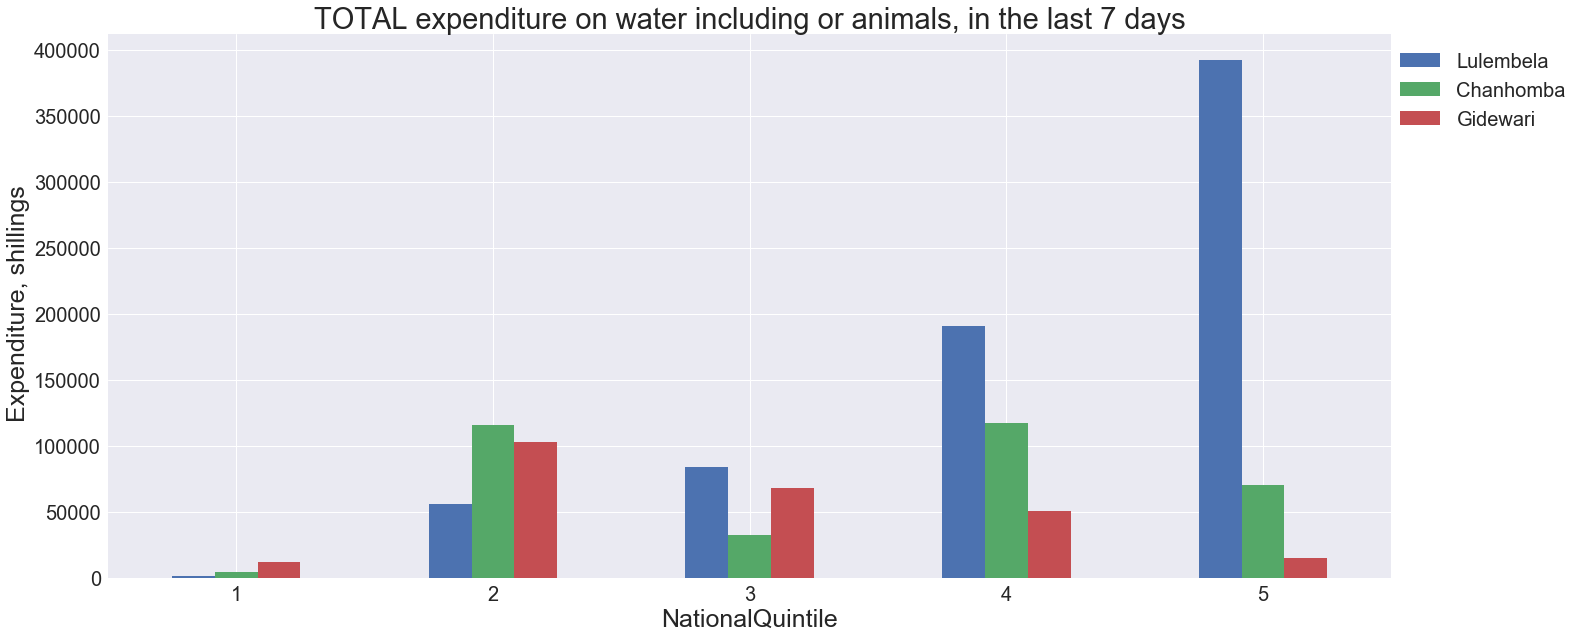

In [68]:
show_diff_between_3_communities_nq(df_Lulembela_m, df_Chanhomba_m, df_Gidewari_m,
                                'WaterExpenditure', 'sum', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'TOTAL expenditure on water including or animals, in the last 7 days',
                                ' Expenditure, shillings')

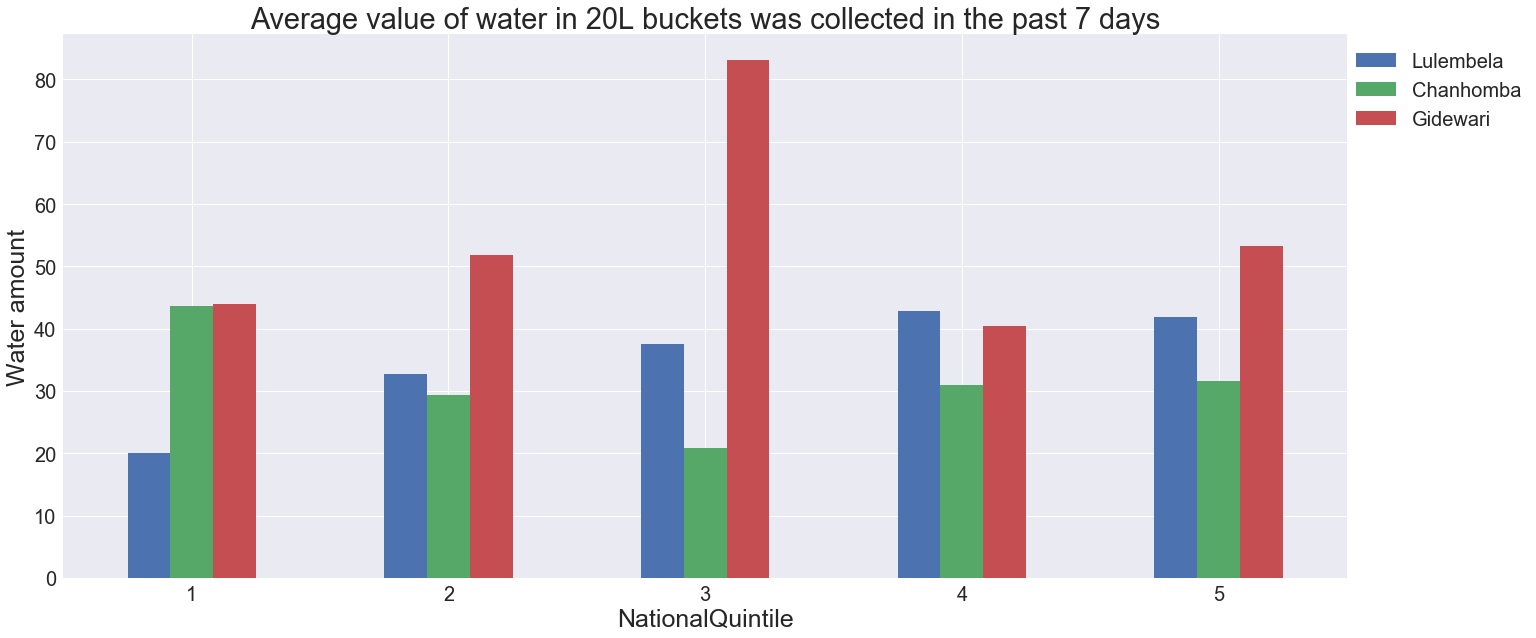

In [69]:
show_diff_between_3_communities_nq(df_Lulembela_m, df_Chanhomba_m, df_Gidewari_m,
                                'AmountOfWater', 'mean', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'Average value of water in 20L buckets was collected in the past 7 days',
                                'Water amount')

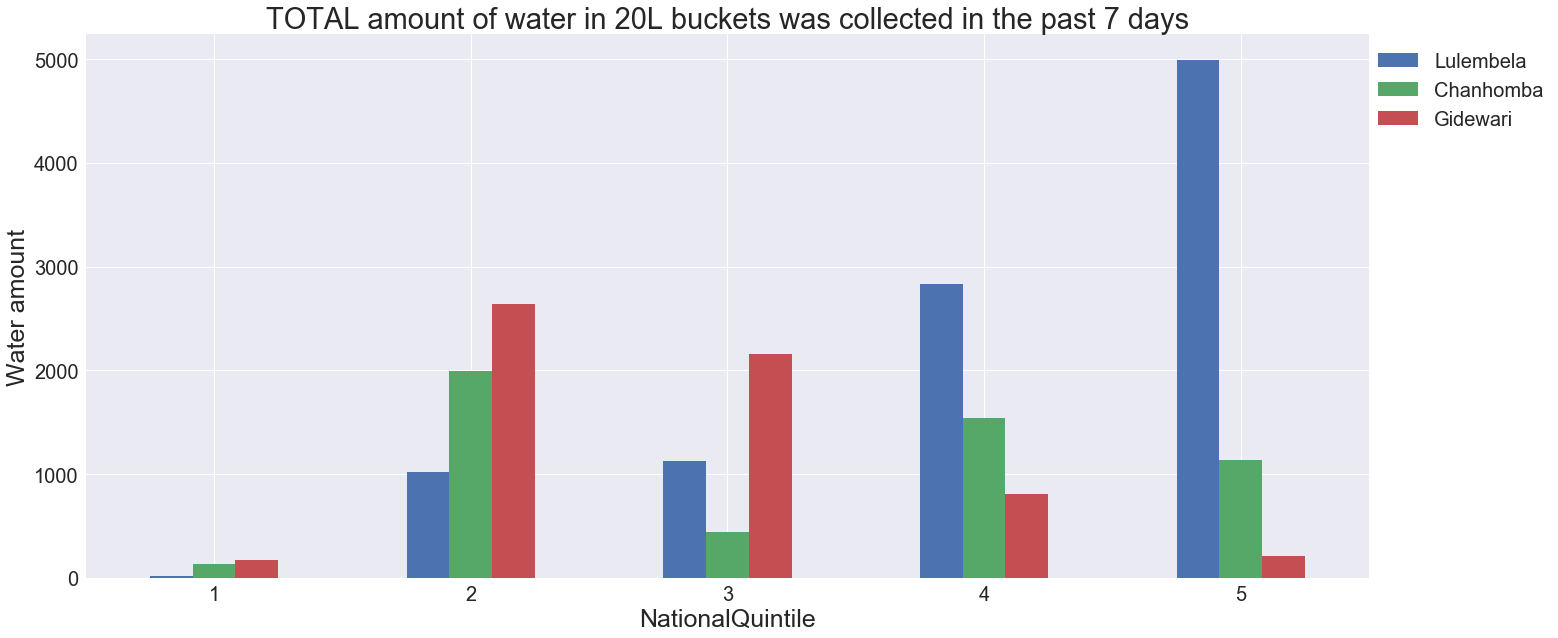

In [70]:
show_diff_between_3_communities_nq(df_Lulembela_m, df_Chanhomba_m, df_Gidewari_m,
                                'AmountOfWater', 'sum', ['Lulembela', 'Chanhomba', 'Gidewari'],
                                'TOTAL amount of water in 20L buckets was collected in the past 7 days',
                                'Water amount')